In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sys
sys.path.append('../module')
import gym2
import matplotlib.pyplot as plt

In [2]:
def h(x, alpha):
    return 1-x[0]**2-alpha*x[1]**2

def u_of_x(x, u_min, u_max, k=2.6, alpha=1):
    assert x.shape[0]==2, 'shape_error'
    assert u_min < u_max, f'input constraint error. {u_min} > {u_max}?'
    al = alpha
    m = 1
    l = 1
    g = 10.
    gamma = pow(10, k)
    th, thd = x
    if thd == 0:
        p = abs(m*g*np.sin(th)/2)
        ran = [u_min, -p] if th > 0 else [p, u_max]
    else:
        u_thres = np.roots([-(6*al*thd)/(m*l**2), -(2*th*thd + 3*al*g/l*thd*np.sin(th) - gamma*h(x, al))])[0]
        if thd < 0:
            if u_thres > u_max:
                print('no cbf compensation')
            u_thres = max(u_thres, u_min)
            ran = [u_thres, u_max]
        else:
            if u_thres < u_min:
                print('no cbf compensation')
            u_thres = min(u_thres, u_max)
            ran = [u_min, u_thres]
    return ran

In [3]:
def u_cbf(u_candidate, ran):
    rmin, rmax = ran[0], ran[1]
    out = u_candidate
    if u_candidate < rmin:
        out = rmin
    elif u_candidate > rmax:
        out = rmax
    else:
        pass
    return out

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= np.pi
    th = np.sign(th) * r
    return th

def dynamics(x, u, dt=0.05):
    m = 1
    l = 1
    g = 10.
    assert x.shape[0] == 2, 'aho'
    th, thdot = x
    th = th + thdot*dt + (3*g)/(2*l)*np.sin(th)*dt**2 + 3/(m*l**2)*u*dt**2
    thdot = thdot + (3*g)/(2*l)*np.sin(th)*dt + 3/(m*l**2)*u*dt
    th, thdot = rad_clip(th), rad_clip(thdot)
    return np.array([th, thdot])

In [4]:
# check cbf condition
import csv

region = []

with open('./CBF/safe_region.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        region.append(row)
region = np.array(region).astype('float64')

In [5]:
h_values = []
alpha = 2.

for i, p in enumerate(region):
    h_values.append([h(p, alpha)])
h_values = np.array(h_values)
region_and_h = np.hstack((region, h_values))

region_and_h = region_and_h[np.argsort(region_and_h[:, 2])]

edge = region_and_h[np.random.permutation(np.arange(300))[0:200], 0:2]

edge = edge[np.argsort(edge[:, 0])]

for p in edge:
    print(p, u_of_x(p, -10., 10., alpha=alpha))

[-0.99835238 -0.00753755] [-9.622193462462583, 10.0]
[-0.98851288 -0.08532906] [1.1214966485984472, 10.0]
[-0.98362388 -0.00262026] [-10.0, 10.0]
[-0.97854214  0.00633848] [-10.0, 10.0]
[-0.97540555 -0.06959203] [-10.0, 10.0]
[-0.97331551 -0.06832945] [-10.0, 10.0]
[-0.97004339 -0.04088795] [-10.0, 10.0]
[-0.96696943 -0.16695631] [2.444657660696186, 10.0]
[-0.96405512  0.14906988] [-10.0, 10.0]
[-0.95778353 -0.16008442] [-2.257363384908872, 10.0]
[-0.95474255  0.07751363] [-10.0, 10.0]
[-0.95289958 -0.07119355] [-10.0, 10.0]
[-0.95270105  0.17649153] [-10.0, 9.884573335802678]
[-0.95205875 -0.12952848] [-10.0, 10.0]
[-0.94921916 -0.0401703 ] [-10.0, 10.0]
[-0.94575641  0.2137008 ] [-10.0, 6.418138346733389]
[-0.94539446 -0.04056244] [-10.0, 10.0]
[-0.9389507   0.17158136] [-10.0, 10.0]
[-0.93870656  0.10381622] [-10.0, 10.0]
[-0.93701563  0.1425917 ] [-10.0, 10.0]
[-0.92328315 -0.25022911] [1.18273837700957, 10.0]
[-0.92203251 -0.20619288] [-6.292258387151004, 10.0]
[-0.90975167  0.200

In [6]:
input_rule = np.clip(np.random.randn(10000,) * 10, -10., 10.)
print(input_rule)

[-10.         -10.          -3.88215479 ...  -6.70645708   8.97593219
  -2.46963275]


In [18]:
x = np.array([-0.75377301, -0.46106032])
print(h(x,alpha))
for i in range(10000):
    u_candidate = input_rule[i]
    u = u_cbf(u_candidate, u_of_x(x, -10., 10., alpha=alpha))
    print(u, u_candidate, u_of_x(x, -10., 10., alpha=alpha))
    x = dynamics(x, u, dt=0.0001)
    print(x, h(x, alpha))
    assert h(x,alpha) >= 0, f'danger state : {x}, h(x) = {h(x, alpha)}'

0.006673012038535098
10.0 10.0 [3.0674450772710955, 10.0]
[-0.75381892 -0.45908696] 0.010235360348090639
2.808125559597611 -9.00095543651748 [2.808125559597611, 10.0]
[-0.75386485 -0.45927122] 0.00982769330116473
2.838045327793697 -8.998648829825793 [2.838045327793697, 10.0]
[-0.75391079 -0.45944655] 0.009436263464949302
10.0 10.0 [2.866755632363016, 10.0]
[-0.75395654 -0.45747334] 0.012985828839662983
2.606579447611351 -10.0 [2.606579447611351, 10.0]
[-0.75400231 -0.45771821] 0.012468603163799719
2.6447464299635626 -4.240765344533053 [2.6447464299635626, 10.0]
[-0.7540481  -0.45795168] 0.011971981142021082
6.325527587202227 6.325527587202227 [2.6813587136624055, 10.0]
[-0.75409381 -0.45708096] 0.013496513272597488
2.569228022712681 -6.809359563214716 [2.569228022712681, 10.0]
[-0.75413955 -0.45733718] 0.012958943953620516
10.0 10.0 [2.6089468368554876, 10.0]
[-0.75418508 -0.45536423] 0.01649170255055682
4.403939134434844 4.403939134434844 [2.3476679931063513, 10.0]
[-0.75423059 -0.455

7.533987528623436 7.533987528623436 [1.2509734074245262, 10.0]
[-0.76061462 -0.44069885] 0.033034440334486936
1.0867864031919312 -3.3535110909823347 [1.0867864031919312, 10.0]
[-0.76065876 -0.44140691] 0.03171811867018609
1.189875855835465 -2.5363890270200478 [1.189875855835465, 10.0]
[-0.76070297 -0.4420841 ] 0.030454290687898233
4.275135881163362 4.275135881163362 [1.2885372297271076, 10.0]
[-0.76074716 -0.44183575] 0.03082610445358458
1.2595020972825197 -5.405085045062661 [1.2595020972825197, 10.0]
[-0.76079141 -0.44249214] 0.029597846645999237
1.3551911312940865 -10.0 [1.3551911312940865, 10.0]
[-0.76083572 -0.44311987] 0.028418564370755683
1.4467933540462088 -2.1694455172894287 [1.4467933540462088, 10.0]
[-0.76088009 -0.44372018] 0.02728630147505401
1.534495710812189 -4.597487232284598 [1.534495710812189, 10.0]
[-0.76092452 -0.44429421] 0.026199180222425178
9.604660019716952 9.604660019716952 [1.6184755778235964, 10.0]
[-0.76096876 -0.44244725] 0.029407401882633466
10.0 10.0 [1.36

[-0.76409078 -0.4414581 ] 0.026394777812475845
5.194833601344077 5.194833601344077 [1.6031837061891814, 10.0]
[-0.76413487 -0.44093752] 0.027246109591978596
1.536955227425468 -7.82682231222699 [1.536955227425468, 10.0]
[-0.76417902 -0.44151435] 0.02616058253719522
3.831441846807722 3.831441846807722 [1.6213672220443471, 10.0]
[-0.76422316 -0.44140288] 0.0262899524077565
1.6113141375545503 -8.601295681152921 [1.6113141375545503, 10.0]
[-0.76426736 -0.4419575 ] 0.02524254413390581
6.84130879586101 6.84130879586101 [1.6925844989711707, 10.0]
[-0.76431145 -0.44094317] 0.026966252091071452
1.5587041702878288 -3.8886916391217015 [1.5587041702878288, 10.0]
[-0.7643556  -0.44151366] 0.025891881858312094
10.0 10.0 [1.6422212906996574, 10.0]
[-0.76439956 -0.43955182] 0.029281711944114497
1.3778531004149546 -0.7554440290182461 [1.3778531004149546, 10.0]
[-0.76444358 -0.44017667] 0.02811502387929421
1.4690884705361642 -9.506780202323643 [1.4690884705361642, 10.0]
[-0.76448765 -0.44077419] 0.026994

10.0 10.0 [1.8367587005616997, 10.0]
[-0.7699114  -0.43616819] 0.0267510502604838
10.0 10.0 [1.573952284473152, 10.0]
[-0.76995482 -0.43421235] 0.030088847608722935
10.0 10.0 [1.3099289205871998, 10.0]
[-0.76999805 -0.43225655] 0.033411560562458587
1.0446720686523787 -5.714824455494569 [1.0446720686523787, 10.0]
[-0.77004135 -0.43298739] 0.03208015907226108
1.151175375963059 -7.680301662921525 [1.151175375963059, 10.0]
[-0.77008472 -0.43368633] 0.030801857500665664
10.0 10.0 [1.253085558478679, 10.0]
[-0.77012789 -0.43173068] 0.03412028368231018
7.926714609423716 7.926714609423716 [0.9875756481418211, 10.0]
[-0.77017093 -0.43039705] 0.036353504118175894
0.8074733252927857 -2.195388164893519 [0.8074733252927857, 10.0]
[-0.77021405 -0.43119924] 0.03490475268685822
2.3810307415440293 2.3810307415440293 [0.9243123660365382, 10.0]
[-0.7702572  -0.43152941] 0.03426858160657875
0.9754374129454039 -5.513631445263445 [0.9754374129454039, 10.0]
[-0.77030043 -0.4322813 ] 0.03290299608521552
1.084

0.8065497731905504 -2.0074976743882784 [0.8065497731905504, 10.0]
[-0.77567046 -0.42635705] 0.034774672779254334
10.0 10.0 [0.9243740414082701, 10.0]
[-0.7757129  -0.42440739] 0.03802623746070111
1.8614322830268015 1.8614322830268015 [0.6579299264914287, 10.0]
[-0.77575539 -0.42489934] 0.03712467663117369
7.443498815417509 7.443498815417509 [0.7319229698343062, 10.0]
[-0.77579776 -0.42371672] 0.03906611703395635
0.8427866050760084 0.8427866050760084 [0.5719826904063555, 10.0]
[-0.77584021 -0.42451436] 0.037647084827772626
0.6887851924535934 -5.07160774278179 [0.6887851924535934, 10.0]
[-0.77588275 -0.42535824] 0.03614669302207779
0.8118033293301519 -10.0 [0.8118033293301519, 10.0]
[-0.77592536 -0.42616527] 0.03470616000260851
0.9294421650358335 -5.418384420693111 [0.9294421650358335, 10.0]
[-0.77596806 -0.42693705] 0.03332309209965956
8.344026217467963 8.344026217467963 [1.0419584128178467, 10.0]
[-0.7760106 -0.4254845] 0.035733429850715204
0.8453401609970758 -2.9977592058634714 [0.845

[-0.78189023 -0.42291182] 0.03093885861606377
1.2264055431513021 -6.07453942921717 [1.2264055431513021, 10.0]
[-0.78193259 -0.42360087] 0.029706025062085306
1.3270639646427818 -7.558812622087212 [1.3270639646427818, 10.0]
[-0.78197502 -0.42425978] 0.028522357248439767
3.339591760229747 3.339591760229747 [1.4233933800071872, 10.0]
[-0.78201745 -0.42431497] 0.028362327676487997
1.4363531940124508 -4.512010613882978 [1.4363531940124508, 10.0]
[-0.78205994 -0.42494117] 0.027232242307558108
2.596771513752563 2.596771513752563 [1.5280058022394039, 10.0]
[-0.78210246 -0.4252193 ] 0.026692825353478222
10.0 10.0 [1.5716396257372114, 10.0]
[-0.78214479 -0.42327651] 0.029923523234718807
1.3090221401136792 1.2879838757422781 [1.3090221401136792, 10.0]
[-0.78218719 -0.42394105] 0.02873118096365962
1.4061629898271586 -5.648241733210964 [1.4061629898271586, 10.0]
[-0.78222964 -0.42457649] 0.027586386654577466
7.153722026420562 7.153722026420562 [1.4991377289356802, 10.0]
[-0.78227199 -0.42348772] 0.0

[-0.78688882 -0.40902309] 0.04620619657183639
-0.07580621293266489 -6.928481160359771 [-0.07580621293266489, 10.0]
[-0.78692984 -0.41010812] 0.04436409669987895
2.0231942159391956 2.0231942159391956 [0.08327707959342448, 10.0]
[-0.78697089 -0.41056349] 0.043552061724671354
10.0 10.0 [0.1530258438115755, 10.0]
[-0.78701175 -0.40862586] 0.04666231599852949
-0.11602658048695766 -10.0 [-0.11602658048695766, 10.0]
[-0.78705273 -0.40972308] 0.044802002655844164
0.044901152742841545 -10.0 [0.044901152742841545, 10.0]
[-0.7870938  -0.41077207] 0.04301596397080676
0.19856454597253817 -7.564601176811047 [0.19856454597253817, 10.0]
[-0.78713498 -0.411775  ] 0.04130122464949898
0.34533037368476627 -0.779672143739532 [0.34533037368476627, 10.0]
[-0.78717625 -0.41273394] 0.03965492948980853
2.3260534112789246 2.3260534112789246 [0.485543469591363, 10.0]
[-0.78721756 -0.41309871] 0.03898740996906236
0.5421186346632942 -9.947714787284983 [0.5421186346632942, 10.0]
[-0.78725896 -0.41399871] 0.037433457

2.099928069401836 -10.0 [2.099928069401836, 10.0]
[-0.79345639 -0.41898275] 0.019333865003457018
2.165271173526612 -9.543321583223086 [2.165271173526612, 10.0]
[-0.79349833 -0.41940238] 0.018563675493990572
2.2278805591459636 -0.41459447993467 [2.2278805591459636, 10.0]
[-0.79354031 -0.41980328] 0.017824181357782465
7.922353903160008 7.922353903160008 [2.287876718230357, 10.0]
[-0.79358216 -0.41849588] 0.019949747553423103
3.211510034782007 3.211510034782007 [2.115129068258833, 10.0]
[-0.79362402 -0.41860178] 0.01970601620606549
2.1349994291158265 -7.1104815502691485 [2.1349994291158265, 10.0]
[-0.79366593 -0.41903067] 0.018920994044204775
7.587798178445637 7.587798178445637 [2.198903827442898, 10.0]
[-0.79370771 -0.41782377] 0.020874673055417348
2.039606255501467 -4.880051197990784 [2.039606255501467, 10.0]
[-0.79374954 -0.41828137] 0.020043070648689487
2.1075309142229957 -3.924201384050802 [2.1075309142229957, 10.0]
[-0.79379141 -0.41871863] 0.01924461438739883
10.0 10.0 [2.172607482

[-0.79925103 -0.40306298] 0.03627827465708905
10.0 10.0 [0.7313605250130885, 10.0]
[-0.79929114 -0.40113827] 0.03930985444185353
4.425610208711841 4.425610208711841 [0.4664570954023058, 10.0]
[-0.79933123 -0.40088592] 0.03965054644704885
0.4363628486488977 -7.5871466362962545 [0.4363628486488977, 10.0]
[-0.79937141 -0.40183039] 0.03807002574095475
9.377170108388462 9.377170108388462 [0.5747117361705348, 10.0]
[-0.79941142 -0.40009266] 0.040793114586739065
3.6614215094207947 3.6614215094207947 [0.3354083874210028, 10.0]
[-0.79945143 -0.40006969] 0.04076590162588489
0.3376169511526336 -8.228353273982478 [0.3376169511526336, 10.0]
[-0.79949153 -0.40104391] 0.0391408591750152
3.8942964402709452 3.8942964402709452 [0.48040388436661813, 10.0]
[-0.79953163 -0.40095116] 0.03922550725289431
0.4727973872366957 -10.0 [0.4727973872366957, 10.0]
[-0.79957182 -0.40188491] 0.037661949603706446
0.6683626296968097 0.6683626296968097 [0.6095567305841203, 10.0]
[-0.79961209 -0.40276003] 0.036189219308124

[-0.80446813 -0.40285033] 0.028254266146470308
6.740637248117311 6.740637248117311 [1.4095874208070025, 10.0]
[-0.80450832 -0.40190887] 0.029704891556566193
9.421663954376111 9.421663954376111 [1.2845410521866998, 10.0]
[-0.80454833 -0.40016315] 0.032440894038555546
1.0471608049286756 -8.283106664387892 [1.0471608049286756, 10.0]
[-0.80458843 -0.40092982] 0.031148031504214968
1.1594295077917447 -9.288778028506956 [1.1594295077917447, 10.0]
[-0.80462859 -0.40166285] 0.029906744804478524
1.2668040412935466 -10.0 [1.2668040412935466, 10.0]
[-0.80466883 -0.40236371] 0.028714971805111955
5.113935044680771 5.113935044680771 [1.3695167052087227, 10.0]
[-0.80470902 -0.40191047] 0.029379343050701168
1.3121524191151461 -5.990228091708257 [1.3121524191151461, 10.0]
[-0.80474928 -0.40259781] 0.02820860592055424
1.4129121994346752 -10.0 [1.4129121994346752, 10.0]
[-0.8047896  -0.40325496] 0.027084562470048645
1.5093212875297488 0.9279211639215 [1.5093212875297488, 10.0]
[-0.80482999 -0.40388324] 0.

[-0.8107291  -0.39467633] 0.031179520168362784
1.1381901913263723 -9.08269941743998 [1.1381901913263723, 10.0]
[-0.81076864 -0.39542209] 0.029936941779365123
1.2475273234440813 1.2062217516297002 [1.2475273234440813, 10.0]
[-0.81080826 -0.3961351 ] 0.028743931971568992
1.3521036025631397 -3.079256678183997 [1.3521036025631397, 10.0]
[-0.81084794 -0.39681678] 0.027598508979965686
1.452144537268533 -0.0367271863122737 [1.452144537268533, 10.0]
[-0.81088768 -0.39746848] 0.026498770658959336
1.5478634165130363 -10.0 [1.5478634165130363, 10.0]
[-0.81092749 -0.39809151] 0.02544289124753324
2.159192238432555 2.159192238432555 [1.6394621042175468, 10.0]
[-0.81096735 -0.39853119] 0.024677746606981132
10.0 10.0 [1.7056394299874353, 10.0]
[-0.81100701 -0.39661866] 0.027654909245164727
1.4468486753664684 -10.0 [1.4468486753664684, 10.0]
[-0.81104674 -0.39727212] 0.026552920785131773
1.5428224458783497 -0.17988150625967894 [1.5428224458783497, 10.0]
[-0.81108653 -0.39789682] 0.02549488121943122
9.9

[-0.81553282 -0.39429559] 0.023968186515349987
1.7597199884571795 -10.0 [1.7597199884571795, 10.0]
[-0.81557231 -0.39485985] 0.02301320142272617
1.8429803079076463 -8.803701666679771 [1.8429803079076463, 10.0]
[-0.81561185 -0.39539918] 0.02209629389499551
1.9226920178607572 -1.0987069844016986 [1.9226920178607572, 10.0]
[-0.81565144 -0.39591463] 0.021215943191308706
10.0 10.0 [1.9990168592036617, 10.0]
[-0.81569084 -0.39400693] 0.024165535652264925
1.7421934798976277 -10.0 [1.7421934798976277, 10.0]
[-0.8157303  -0.39457661] 0.02320268085982924
1.8262288449417483 -10.0 [1.8262288449417483, 10.0]
[-0.81576981 -0.39512112] 0.02227821801505364
1.9066800496861098 -6.407927980832841 [1.9066800496861098, 10.0]
[-0.81580938 -0.39564154] 0.021390613769664835
1.983710662688552 -10.0 [1.983710662688552, 10.0]
[-0.81584899 -0.39613888] 0.02053839623528636
2.0574759105310756 -10.0 [2.0574759105310756, 10.0]
[-0.81588865 -0.39661414] 0.019720152500361243
2.1281231772182703 -6.577394996866096 [2.128

1.5624319207512032 -5.078991733098261 [1.5624319207512032, 10.0]
[-0.82092695 -0.38797214] 0.025034181369603947
3.345227027625853 3.345227027625853 [1.6550313670896717, 10.0]
[-0.82096576 -0.38806628] 0.024824355007049215
1.6736273209035757 -5.591031573449476 [1.6736273209035757, 10.0]
[-0.82100462 -0.38866194] 0.023835209036675686
1.7614507343419585 -0.23734444139137886 [1.7614507343419585, 10.0]
[-0.82104354 -0.38923129] 0.02288550710104198
1.845512428986761 -1.6110715865860477 [1.845512428986761, 10.0]
[-0.82108252 -0.38977546] 0.021973673505774283
10.0 10.0 [1.9259854041543467, 10.0]
[-0.82112131 -0.38787333] 0.02486836193454639
1.669363530923693 -9.433277735411735 [1.669363530923693, 10.0]
[-0.82116016 -0.38847042] 0.02387746040430716
1.757395272550327 -0.6592682587108158 [1.757395272550327, 10.0]
[-0.82119906 -0.38904115] 0.0229260731037228
10.0 10.0 [1.8416555720156011, 10.0]
[-0.82123777 -0.38713913] 0.025815101714368405
2.0584844550077803 2.0584844550077803 [1.584615714754793,

[-0.82577857 -0.37889122] 0.030972634207928507
10.0 10.0 [1.1010548719876174, 10.0]
[-0.82581627 -0.37699387] 0.033778724052902775
0.8406032105812076 -10.0 [0.8406032105812076, 10.0]
[-0.82585405 -0.37784438] 0.03243232225796938
6.962047904235009 6.962047904235009 [0.9656457756066693, 10.0]
[-0.82589174 -0.3768585 ] 0.03385817606578889
2.8198249017006427 2.8198249017006427 [0.832809487056883, 10.0]
[-0.82592945 -0.37711532] 0.03340861262037048
2.7340995246130246 2.7340995246130246 [0.8745224224495521, 10.0]
[-0.82596719 -0.37739789] 0.0329198561317639
5.714826259617861 5.714826259617861 [0.9198219135840552, 10.0]
[-0.82600487 -0.37678629] 0.03378013617603559
0.8395118838885578 -9.559838943129833 [0.8395118838885578, 10.0]
[-0.82604263 -0.37763732] 0.03243367635597516
0.9646359931863138 -0.10526923392094514 [0.9646359931863138, 10.0]
[-0.82608048 -0.37845085] 0.03114095083389601
5.617592599333835 5.617592599333835 [1.0842178806980864, 10.0]
[-0.82611827 -0.37786853] 0.03195935711063885


[-0.83110025 -0.37303525] 0.030961774825060462
1.0783228302945544 -0.336952170017229 [1.0783228302945544, 10.0]
[-0.83113763 -0.3738198 ] 0.02972774513084625
1.1937511918581962 0.9560228980778513 [1.1937511918581962, 10.0]
[-0.83117509 -0.37456976] 0.0285429547118789
1.3041027220922843 -2.84277348309479 [1.3041027220922843, 10.0]
[-0.83121262 -0.37528666] 0.02740543392559125
10.0 10.0 [1.4096222752637972, 10.0]
[-0.83124996 -0.37339482] 0.03017612724917268
1.1513075513260909 -8.226462504101136 [1.1513075513260909, 10.0]
[-0.83128737 -0.37415762] 0.02897344553275283
1.2635446284044978 -0.9934413783698877 [1.2635446284044978, 10.0]
[-0.83132486 -0.3748868 ] 0.027818749155338773
1.3708588606446832 -1.2868006202403512 [1.3708588606446832, 10.0]
[-0.83136242 -0.37558382] 0.02671011891271846
10.0 10.0 [1.4734865077761, 10.0]
[-0.83139979 -0.37369213] 0.029482773934455753
1.2155249253940479 -0.04233560750172462 [1.2155249253940479, 10.0]
[-0.83143723 -0.37443582] 0.028307755775932864
10.0 10.

[-0.83539994 -0.37816639] 0.016087304760018184
2.435758472249349 -10.0 [2.435758472249349, 10.0]
[-0.83543779 -0.37854805] 0.015446443480113314
10.0 10.0 [2.493479136370071, 10.0]
[-0.83547546 -0.37666047] 0.01823453478830206
2.2412576125082118 -1.8377025322964957 [2.2412576125082118, 10.0]
[-0.83551317 -0.37710056] 0.017508085415061603
2.6476004925591696 2.6476004925591696 [2.3071744133474335, 10.0]
[-0.83555091 -0.37741878] 0.016964811415895342
10.0 10.0 [2.35636045482606, 10.0]
[-0.83558846 -0.37553131] 0.01974438574718501
2.1034413811419093 -6.0030136785323585 [2.1034413811419093, 10.0]
[-0.83562606 -0.37601286] 0.018957745118870828
2.175212836300566 -10.0 [2.175212836300566, 10.0]
[-0.83566371 -0.3764729 ] 0.018202465139264545
4.754211802447122 4.754211802447122 [2.2439462108760506, 10.0]
[-0.83570133 -0.37615929] 0.018611665639135522
2.2066516063296504 -9.13321189553804 [2.2066516063296504, 10.0]
[-0.83573899 -0.37660998] 0.017870181891004533
2.274065879631777 -7.826715797820439 

3.5448054516803156 3.5448054516803156 [1.6454041712613283, 10.0]
[-0.83987707 -0.36754971] 0.024420940285689807
10.0 10.0 [1.6585134649557147, 10.0]
[-0.83991363 -0.36566658] 0.027120987109554073
1.402324563262847 1.1391038584673758 [1.402324563262847, 10.0]
[-0.83995027 -0.3663628 ] 0.02604013978451558
1.5050039151937529 -10.0 [1.5050039151937529, 10.0]
[-0.83998697 -0.36702825] 0.025002410516541618
3.729656873665819 3.729656873665819 [1.6032079336957283, 10.0]
[-0.84002368 -0.36702634] 0.024943551855557244
3.5860304411507826 3.5860304411507826 [1.6086450338209437, 10.0]
[-0.84006038 -0.36706756] 0.024821368598409
1.620069743765347 -8.686094373832315 [1.620069743765347, 10.0]
[-0.84009715 -0.3676986 ] 0.02383225427451524
1.713291420163106 -9.166354009430949 [1.713291420163106, 10.0]
[-0.84013398 -0.36830171] 0.022882590744113196
8.485871290707488 8.485871290707488 [1.8024846750395664, 10.0]
[-0.84017067 -0.36687309] 0.024921524336247836
1.6102100912341533 -8.293265239003413 [1.6102100

10.0 10.0 [2.081231238093201, 10.0]
[-0.84383318 -0.36431135] 0.022500046554998654
1.8276785290268969 0.5338582524529913 [1.8276785290268969, 10.0]
[-0.84386967 -0.36488388] 0.02160349703783232
9.33160758171052 9.33160758171052 [1.912535939256726, 10.0]
[-0.84390599 -0.36320526] 0.023986559541392227
1.6859129979904512 -10.0 [1.6859129979904512, 10.0]
[-0.84394237 -0.36382039] 0.023030722811180626
6.603454646294997 6.603454646294997 [1.7769039540167206, 10.0]
[-0.84397866 -0.36296029] 0.02421966197897074
1.6633816537155046 -8.379154202323278 [1.6633816537155046, 10.0]
[-0.84401502 -0.36358226] 0.023254527284318427
3.625756353402279 3.625756353402279 [1.7553605823915, 10.0]
[-0.84405138 -0.36361554] 0.023144737278419814
1.7656987139903868 -6.428298818355662 [1.7656987139903868, 10.0]
[-0.84408781 -0.36420688] 0.022222475390201668
2.7789329595383987 2.7789329595383987 [1.8532631936068211, 10.0]
[-0.84412425 -0.36449428] 0.021742077102075597
1.8987114408035768 -1.3819240989301198 [1.898711

4.606491034840699 4.606491034840699 [1.9252426030288357, 10.0]
[-0.84698393 -0.36119771] 0.02169065259795816
10.0 10.0 [1.8953344605373434, 10.0]
[-0.84701986 -0.35932167] 0.0243332220132903
10.0 10.0 [1.6410735134795957, 10.0]
[-0.84705561 -0.35744567] 0.026961977872480947
1.3854239729606528 -10.0 [1.3854239729606528, 10.0]
[-0.84709142 -0.35815408] 0.025887426360201415
2.1504349402793843 2.1504349402793843 [1.4900332378905086, 10.0]
[-0.84712729 -0.35863302] 0.025140067810119182
1.5624952317633702 -8.55779289691521 [1.5624952317633702, 10.0]
[-0.84716322 -0.35928838] 0.024138201183193597
1.6593714915826707 -0.041657321197209364 [1.6593714915826707, 10.0]
[-0.84719921 -0.35991471] 0.023176298720808952
9.788222703226737 9.788222703226737 [1.7520399190163458, 10.0]
[-0.84723502 -0.35810243] 0.025718127990222217
1.505870920564746 -10.0 [1.505870920564746, 10.0]
[-0.8472709  -0.35877488] 0.02469320022516125
10.0 10.0 [1.6052355464994952, 10.0]
[-0.84730659 -0.35689913] 0.02731757179636529

6.699051972041792 6.699051972041792 [0.3799571319490555, 10.0]
[-0.85031686 -0.34571178] 0.03792796852969549
0.25947891615382923 -1.6591590284695903 [0.25947891615382923, 10.0]
[-0.85035154 -0.3467612 ] 0.03641559920263335
0.4153066233918495 -6.168324638648746 [0.4153066233918495, 10.0]
[-0.85038631 -0.34776392] 0.03496363776009764
0.5639851364922241 -2.1473126321344065 [0.5639851364922241, 10.0]
[-0.85042118 -0.34872206] 0.03356966202895434
0.7058858924038821 -6.799370717157308 [0.7058858924038821, 10.0]
[-0.85045615 -0.34963766] 0.032231347838222485
0.8413571378600405 -10.0 [0.8413571378600405, 10.0]
[-0.8504912  -0.35051266] 0.030946464964707432
0.9707257306272526 -9.913837964004573 [0.9707257306272526, 10.0]
[-0.85052633 -0.35134889] 0.029712873256152905
1.0942987685760306 -6.694753968037041 [1.0942987685760306, 10.0]
[-0.85056155 -0.35214807] 0.02852851892297542
1.2123650661117256 -2.960089240920965 [1.2123650661117256, 10.0]
[-0.85059684 -0.35291188] 0.027391430990239857
1.325196

10.0 10.0 [1.5160480759816901, 10.0]
[-0.85356802 -0.34895966] 0.027875959219031632
1.2602458895161412 -3.7288560947939855 [1.2602458895161412, 10.0]
[-0.85360299 -0.34971206] 0.026764887272843624
1.371470848131282 -3.5664754663411347 [1.371470848131282, 10.0]
[-0.85363803 -0.35043114] 0.025698151474361608
6.649944851275091 6.649944851275091 [1.4777906637288614, 10.0]
[-0.85367299 -0.3495667 ] 0.02684867384243117
1.3627049702709282 -1.4243061289924381 [1.3627049702709282, 10.0]
[-0.85370802 -0.35028847] 0.025778594237338776
1.4694227908900304 -3.103035221817379 [1.4694227908900304, 10.0]
[-0.85374311 -0.35097826] 0.024751210811890245
1.5714538889335234 -10.0 [1.5714538889335234, 10.0]
[-0.85377828 -0.35163748] 0.023764815774643178
1.6690237316215562 -10.0 [1.6690237316215562, 10.0]
[-0.8538135  -0.35226746] 0.02281777002008839
10.0 10.0 [1.7623452617535476, 10.0]
[-0.85384854 -0.35039818] 0.025384888426365715
6.828752277423776 6.828752277423776 [1.5079483313095974, 10.0]
[-0.85388349 -

1.2466892199530355 -6.308698325419444 [1.2466892199530355, 10.0]
[-0.85927843 -0.34283818] 0.02656454593318794
2.0728460796714367 2.0728460796714367 [1.3594859990971526, 10.0]
[-0.85931276 -0.34335242] 0.025799808252282896
3.0154325923389864 3.0154325923389864 [1.437344703525057, 10.0]
[-0.85934712 -0.34358391] 0.025422713380337136
1.4755535235945119 -7.720919157751318 [1.4755535235945119, 10.0]
[-0.85938155 -0.34427741] 0.02440948835881865
1.5782537507078516 -9.738335413504297 [1.5782537507078516, 10.0]
[-0.85941604 -0.34494012] 0.02343668912938937
2.7257584192822444 2.7257584192822444 [1.6764529452759234, 10.0]
[-0.85945057 -0.34525862] 0.02293768933418036
10.0 10.0 [1.7265992366599738, 10.0]
[-0.85948491 -0.34339488] 0.025445604676495787
1.4724634336279816 -10.0 [1.4724634336279816, 10.0]
[-0.85951932 -0.34408943] 0.024431465245832645
1.575322548558713 -2.8437048401903358 [1.575322548558713, 10.0]
[-0.85955379 -0.34475316] 0.023457788276774194
7.1956412100256895 7.1956412100256895 [

[-0.86226731 -0.34128987] 0.02353753457310745
1.652309048517942 -0.2482376569426417 [1.652309048517942, 10.0]
[-0.86230151 -0.34193319] 0.022599503053552267
2.553689108712805 2.553689108712805 [1.7477419109554606, 10.0]
[-0.86233574 -0.34230613] 0.022030107397521037
5.154894486996988 5.154894486996988 [1.8054325380687275, 10.0]
[-0.86236993 -0.34189874] 0.02252861412026197
4.070716845954828 4.070716845954828 [1.754633575990853, 10.0]
[-0.86240411 -0.34181664] 0.022581926870677005
1.749051043414332 -4.709420041444167 [1.749051043414332, 10.0]
[-0.86243835 -0.34243107] 0.02168201628181632
1.840286446489405 0.21066857468152478 [1.840286446489405, 10.0]
[-0.86247265 -0.34301816] 0.020818002019680037
1.9275636906329592 -4.347836105189274 [1.9275636906329592, 10.0]
[-0.86250701 -0.34357911] 0.019988449177418904
9.09861755361279 9.09861755361279 [2.0110690877549446, 10.0]
[-0.86254121 -0.34198877] 0.02211002393254788
2.359780554664831 2.359780554664831 [1.7964013082574075, 10.0]
[-0.86257545 

9.681668713190938 9.681668713190938 [0.8099866200335331, 10.0]
[-0.86546799 -0.32963239] 0.03365013237908601
10.0 10.0 [0.5645467770449414, 10.0]
[-0.86550076 -0.32777452] 0.036036148852678446
0.30396233799890904 -10.0 [0.30396233799890904, 10.0]
[-0.86553365 -0.3288255 ] 0.034599089917007636
7.939279398529431 7.939279398529431 [0.4607185644049696, 10.0]
[-0.86556641 -0.32758591] 0.036169743573266244
10.0 10.0 [0.2885564124920546, 10.0]
[-0.86559898 -0.32572813] 0.03854077501635178
0.026284653209259566 -1.0973478509978896 [0.026284653209259566, 10.0]
[-0.86563166 -0.3268625 ] 0.03700362667710819
0.1960351841976013 -3.176715654035841 [0.1960351841976013, 10.0]
[-0.86566446 -0.32794598] 0.03552790757896748
0.35784169568179675 -10.0 [0.35784169568179675, 10.0]
[-0.86569736 -0.32898095] 0.03411115156414549
9.331677844238694 9.331677844238694 [0.5121313259804466, 10.0]
[-0.86573009 -0.3273238 ] 0.03622966921565346
0.280107265979641 -10.0 [0.280107265979641, 10.0]
[-0.86576293 -0.32838215] 0

1.3702852427393406 -9.477477013675127 [1.3702852427393406, 10.0]
[-0.86981674 -0.33063328] 0.02478209402147069
2.638352215242347 2.638352215242347 [1.4793988833884717, 10.0]
[-0.86984984 -0.33098813] 0.02425497035006874
1.5350116244354362 -5.512965811399495 [1.5350116244354362, 10.0]
[-0.86988301 -0.331674  ] 0.02328825883776764
4.045855383415542 4.045855383415542 [1.636846528644462, 10.0]
[-0.86991617 -0.33160666] 0.02331990228305386
10.0 10.0 [1.6333201469581093, 10.0]
[-0.86994915 -0.3297531 ] 0.02571426411904862
1.3794273689567498 -6.841776554846839 [1.3794273689567498, 10.0]
[-0.86998219 -0.33048575] 0.0246893165547451
8.929647301236805 8.929647301236805 [1.4881633035954005, 10.0]
[-0.87001509 -0.32895337] 0.026653109556246807
1.2786770371219975 0.9812372383206879 [1.2786770371219975, 10.0]
[-0.87004806 -0.3297163 ] 0.02559069021145921
1.391907853391162 -10.0 [1.391907853391162, 10.0]
[-0.87008111 -0.3304453 ] 0.024570673514053815
1.5001066588208087 -10.0 [1.5001066588208087, 10.0

0.9458239981487132 -10.0 [0.9458239981487132, 10.0]
[-0.87309281 -0.32357332] 0.02830955765632412
4.618711874214979 4.618711874214979 [1.0745673780140401, 10.0]
[-0.87312514 -0.32333722] 0.02855857097662723
1.0470074821723392 -10.0 [1.0470074821723392, 10.0]
[-0.87315756 -0.32417266] 0.02742005053328736
1.1711839642437756 -10.0 [1.1711839642437756, 10.0]
[-0.87319006 -0.32497088] 0.026326983306895896
1.2897753808906838 -10.0 [1.2897753808906838, 10.0]
[-0.87322263 -0.32573355] 0.0252775488410997
1.4030620539940692 -2.431831806850662 [1.4030620539940692, 10.0]
[-0.87325527 -0.32646227] 0.024270000127404018
6.8430855722598505 6.8430855722598505 [1.5113076794446898, 10.0]
[-0.87328783 -0.32555901] 0.025391027173166242
1.3903382377115803 -4.800237151755191 [1.3903382377115803, 10.0]
[-0.87332046 -0.32629161] 0.024378948826555003
10.0 10.0 [1.4991605803907277, 10.0]
[-0.8733529  -0.32444134] 0.026730342794925005
1.2446934776755914 -3.9567232867252473 [1.2446934776755914, 10.0]
[-0.87338543 

[-0.87776205 -0.31356717] 0.0328850475346317
10.0 10.0 [0.5135908225173038, 10.0]
[-0.87779322 -0.31172117] 0.03513889219559432
10.0 10.0 [0.25322125014505853, 10.0]
[-0.87782421 -0.3098752 ] 0.037379391278693525
10.0 10.0 [-0.008823190816554263, 10.0]
[-0.87785501 -0.30802925] 0.0396065456901423
2.231069262047636 2.231069262047636 [-0.27257262504525837, 10.0]
[-0.87788586 -0.30851402] 0.03895462215467807
-0.1956626164992836 -10.0 [-0.1956626164992836, 10.0]
[-0.87791683 -0.30972683] 0.037400618361191934
10.0 10.0 [-0.012702584436507352, 10.0]
[-0.87794762 -0.30788097] 0.039626588317552836
-0.27647549351378403 -10.0 [-0.27647549351378403, 10.0]
[-0.87797853 -0.30911809] 0.038045709859199806
2.6543480060936093 2.6543480060936093 [-0.08961771405354697, 10.0]
[-0.87800948 -0.30947599] 0.03754857755738683
8.443137150990681 8.443137150990681 [-0.0314994245287576, 10.0]
[-0.87804029 -0.30809728] 0.03919738055533384
8.923812454173717 8.923812454173717 [-0.2269496320438476, 10.0]
[-0.87807095 

[-0.88036824 -0.30273522] 0.04165454241928873
10.0 10.0 [-0.563167129334343, 10.0]
[-0.88039833 -0.3008917 ] 0.04382714824940581
-0.8305801139026515 -2.631770045304529 [-0.8305801139026515, 10.0]
[-0.88042856 -0.3022974 ] 0.04207812293426419
9.336969767785614 9.336969767785614 [-0.6160619833860121, 10.0]
[-0.88045862 -0.30065285] 0.04400833828996811
-0.8542105140589594 -3.785286566819101 [-0.8542105140589594, 10.0]
[-0.88048883 -0.30206569] 0.04225205816576655
2.3151920700615456 2.3151920700615456 [-0.6385054070728187, 10.0]
[-0.88051908 -0.30252774] 0.04164008207061973
3.786746245281817 3.786746245281817 [-0.5642065440292731, 10.0]
[-0.88054934 -0.30254835] 0.04156186086898306
7.28709862720812 7.28709862720812 [-0.5552168695204824, 10.0]
[-0.88057949 -0.30151888] 0.042752494824565945
10.0 10.0 [-0.7016795060523527, 10.0]
[-0.88060946 -0.29967557] 0.04491609108009509
-0.9700344083844205 -5.555995209683199 [-0.9700344083844205, 10.0]
[-0.88063957 -0.3011233 ] 0.04312346709440576
-0.7485

1.6006855657053887 -2.815105951816867 [1.6006855657053887, 10.0]
[-0.88450579 -0.31291361] 0.021819651459377865
1.7020731385365557 -9.616887593687064 [1.7020731385365557, 10.0]
[-0.88453715 -0.31356342] 0.020949997746529475
1.798982764376276 -10.0 [1.798982764376276, 10.0]
[-0.88456856 -0.31418419] 0.020115044354392847
1.8916321066735744 -2.77070848843766 [1.8916321066735744, 10.0]
[-0.88460004 -0.31477719] 0.01931340321673622
1.9802265379374082 -10.0 [1.9802265379374082, 10.0]
[-0.88463158 -0.31534365] 0.01854374210331397
2.0649599832467813 -2.1404713676181486 [2.0649599832467813, 10.0]
[-0.88466316 -0.31588471] 0.0178047823444219
2.146015692862455 0.5954833062331534 [2.146015692862455, 10.0]
[-0.88469481 -0.31640149] 0.017095296651149117
2.22356695105068 -7.834722948954313 [2.22356695105068, 10.0]
[-0.88472649 -0.31689503] 0.01641410702698326
2.2977777274058657 -10.0 [2.2977777274058657, 10.0]
[-0.88475823 -0.31736634] 0.015760082766649863
5.309112384814487 5.309112384814487 [2.36880

2.2570812700281246 -10.0 [2.2570812700281246, 10.0]
[-0.88808665 -0.31250369] 0.01598499658751315
2.3303668614179136 1.8092504378497962 [2.3303668614179136, 10.0]
[-0.88811794 -0.31296841] 0.015348069946349685
10.0 10.0 [2.400506749049852, 10.0]
[-0.88814906 -0.31113227] 0.01758467932438193
3.941935128507246 3.941935128507246 [2.152522180959981, 10.0]
[-0.88818017 -0.31111357] 0.01755267857750259
2.1559252375105356 -10.0 [2.1559252375105356, 10.0]
[-0.88821133 -0.31163071] 0.016853229466766012
2.2335967748998544 -7.963013824550621 [2.2335967748998544, 10.0]
[-0.88824254 -0.31212458] 0.016181676992786193
2.411680729087858 2.411680729087858 [2.3079183260771137, 10.0]
[-0.8882738  -0.31256505] 0.01557583281016936
2.374750078026754 -10.0 [2.374750078026754, 10.0]
[-0.8883051  -0.31301663] 0.014955221660688606
4.444538906985549 4.444538906985549 [2.443015584780163, 10.0]
[-0.88833639 -0.31284731] 0.015111590378601436
2.425679585451783 -10.0 [2.425679585451783, 10.0]
[-0.88836772 -0.31328367

[-0.89153228 -0.29994437] 0.02523694811601801
10.0 10.0 [1.2474113229662778, 10.0]
[-0.89156209 -0.29811145] 0.027376167785688826
2.8938532924207774 2.8938532924207774 [0.9922825096244168, 10.0]
[-0.89159193 -0.2984104 ] 0.026966292474490478
10.0 10.0 [1.0410009756355403, 10.0]
[-0.89162159 -0.29657754] 0.02909446907155208
10.0 10.0 [0.7845105795865861, 10.0]
[-0.89165106 -0.2947447 ] 0.031209500471530316
0.5263083106709388 -10.0 [0.5263083106709388, 10.0]
[-0.89168064 -0.295754  ] 0.02996477679408832
10.0 10.0 [0.6780185142846723, 10.0]
[-0.89171003 -0.29392123] 0.03207384864151311
0.4191003105015986 -10.0 [0.4191003105015986, 10.0]
[-0.89173953 -0.29496274] 0.030794576926378103
7.998437021357018 7.998437021357018 [0.5758656488753789, 10.0]
[-0.8917689  -0.29373049] 0.032193030511973364
0.403483057059088 -1.7537408951451738 [0.403483057059088, 10.0]
[-0.89179838 -0.29477675] 0.03090899347390974
0.560997835776545 -5.053983824427458 [0.560997835776545, 10.0]
[-0.89182795 -0.29577578] 0.

2.259880768878768 1.2170435491626241 [2.259880768878768, 10.0]
[-0.89522939 -0.30241886] 0.015650010865247838
2.334148558620915 -10.0 [2.334148558620915, 10.0]
[-0.89525968 -0.30288917] 0.015026410835098286
2.405217322507139 -10.0 [2.405217322507139, 10.0]
[-0.89529001 -0.30333819] 0.014427679622183692
10.0 10.0 [2.4732357549939548, 10.0]
[-0.89532016 -0.3015088 ] 0.016586688434890973
2.22620112057009 0.9852451506736533 [2.22620112057009, 10.0]
[-0.89535036 -0.30201158] 0.015925729796905902
2.3019443842155254 1.9007315136321636 [2.3019443842155254, 10.0]
[-0.89538061 -0.30249167] 0.015291132955841141
10.0 10.0 [2.3744195511259147, 10.0]
[-0.89541068 -0.30066237] 0.017443991368248646
2.1267649447914816 -0.3274585709394994 [2.1267649447914816, 10.0]
[-0.8954408  -0.30119507] 0.01674883576192082
10.0 10.0 [2.2068373341036875, 10.0]
[-0.89547074 -0.29936582] 0.01889236780682091
3.1626515100520356 3.1626515100520356 [1.958117932554656, 10.0]
[-0.89550069 -0.29958781] 0.018572791675276062
1.

2.060308229241897 -2.1706832759182744 [2.060308229241897, 10.0]
[-0.89965732 -0.29457969] 0.01706231861273752
2.1439519154646747 -2.7904863924475 [2.1439519154646747, 10.0]
[-0.89968683 -0.2951112 ] 0.016382361524028277
2.223948361155716 -10.0 [2.223948361155716, 10.0]
[-0.89971639 -0.29561874] 0.015729528023680855
4.799214651406399 4.799214651406399 [2.3004708715365267, 10.0]
[-0.89974593 -0.29535373] 0.015989608615363166
2.269770193655746 2.082122029889536 [2.269770193655746, 10.0]
[-0.89977551 -0.29584758] 0.015352440717716881
2.3443155603564834 -5.899898257508171 [2.3443155603564834, 10.0]
[-0.89980515 -0.2963191 ] 0.014740685964081873
2.4156435353895347 -10.0 [2.4156435353895347, 10.0]
[-0.89983482 -0.29676924] 0.01415332873857994
2.483904212924006 -10.0 [2.483904212924006, 10.0]
[-0.89986454 -0.29719893] 0.013589394190563514
2.5492397462309846 -9.402388396494166 [2.5492397462309846, 10.0]
[-0.8998943  -0.29760905] 0.013047946582160935
10.0 10.0 [2.6117848479069425, 10.0]
[-0.8999

-0.20037870494718563 -10.0 [-0.20037870494718563, 10.0]
[-0.90323733 -0.27420087] 0.033790088947693864
6.988273937753106 6.988273937753106 [-0.011051718791262675, 10.0]
[-0.90326466 -0.27328242] 0.03474639693582687
5.099180406066043 5.099180406066043 [-0.1407952030641923, 10.0]
[-0.90329195 -0.27293072] 0.03508129750573244
-0.18684988377589914 -10.0 [-0.18684988377589914, 10.0]
[-0.90331937 -0.27416485] 0.033681388228337356
0.0018321859120212988 -9.961576783437048 [0.0018321859120212988, 10.0]
[-0.9033469  -0.27534241] 0.032337493209199875
10.0 10.0 [0.18127621336544264, 10.0]
[-0.90337425 -0.27352054] 0.034287989668776137
10.0 10.0 [-0.0811648901881741, 10.0]
[-0.90340142 -0.27169869] 0.036225509545818824
-0.3455424664313129 -10.0 [-0.3455424664313129, 10.0]
[-0.90342872 -0.27298053] 0.03477979990371305
-0.14898430373739285 -9.634240385814493 [-0.14898430373739285, 10.0]
[-0.90345614 -0.27420343] 0.0333919506517211
2.3173000032941062 2.3173000032941062 [0.03787052737394285, 10.0]
[-0.

1.927165852158926 1.927165852158926 [1.1581016628595717, 10.0]
[-0.90746443 -0.27644239] 0.023667520131560316
1.2506517258081566 -10.0 [1.2506517258081566, 10.0]
[-0.90749215 -0.27724914] 0.022723822002641197
1.3719293427482975 -6.94369112912696 [1.3719293427482975, 10.0]
[-0.90751996 -0.27801953] 0.021817814284399634
1.4876666154937972 -4.047265956746356 [1.4876666154937972, 10.0]
[-0.90754783 -0.27875522] 0.020947986026930293
1.5981494118189052 -8.575283808130681 [1.5981494118189052, 10.0]
[-0.90757578 -0.2794578 ] 0.020112887380657724
1.7036459257860272 -10.0 [1.7036459257860272, 10.0]
[-0.90760379 -0.28012875] 0.019311127072331097
2.3104904954121275 2.3104904954121275 [1.8044080347055018, 10.0]
[-0.90763185 -0.28061767] 0.01871186248796497
1.8793309355016492 1.863991417418493 [1.8793309355016492, 10.0]
[-0.90765998 -0.28123597] 0.017966023064323572
5.160825697990657 5.160825697990657 [1.972267556889289, 10.0]
[-0.90768806 -0.28086985] 0.01832663591434447
8.37206121946448 8.37206121

[-0.9109256  -0.27240036] 0.021810635245055998
1.445864450567384 -10.0 [1.445864450567384, 10.0]
[-0.91095292 -0.27315173] 0.020941044096254247
10.0 10.0 [1.5588756363629577, 10.0]
[-0.91098005 -0.27133689] 0.022867930719879415
6.015335131559855 6.015335131559855 [1.3063567892695007, 10.0]
[-0.91100713 -0.27071747] 0.023490123178830286
1.2237990725808146 0.8445784661149279 [1.2237990725808146, 10.0]
[-0.91103428 -0.27153554] 0.02255344924280836
1.3470001361724602 -10.0 [1.3470001361724602, 10.0]
[-0.91106151 -0.27231667] 0.021654189664043783
3.2718419650077992 3.2718419650077992 [1.4645466257609143, 10.0]
[-0.91108876 -0.27252037] 0.021382560681601354
10.0 10.0 [1.4996736804513893, 10.0]
[-0.91111583 -0.27070565] 0.023304836533624806
2.643789081371064 2.643789081371064 [1.2467320076620159, 10.0]
[-0.91114294 -0.27109782] 0.022830477005691935
2.1960114652799327 2.1960114652799327 [1.3090009272247105, 10.0]
[-0.91117011 -0.27162435] 0.022209461075341413
3.5459881204787087 3.5459881204787

[-0.9135937 -0.2736635] 0.015563138587943198
2.2241033212406562 -7.23283734701842 [2.2241033212406562, 10.0]
[-0.91362111 -0.27418385] 0.014942894024143116
4.367706464465938 4.367706464465938 [2.3028203438322112, 10.0]
[-0.91364852 -0.27406114] 0.015027360826934011
2.2918742403423487 -0.8483930495239103 [2.2918742403423487, 10.0]
[-0.91367598 -0.27456121] 0.014428490972533015
10.0 10.0 [2.367638098620789, 10.0]
[-0.91370325 -0.27274887] 0.01636247686965067
10.0 10.0 [2.1209025509611887, 10.0]
[-0.91373034 -0.27093655] 0.01828362721860141
1.872436214873166 1.2125752222300725 [1.872436214873166, 10.0]
[-0.9137575  -0.27156253] 0.01755481712667753
6.523867715255431 6.523867715255431 [1.9667198027332506, 10.0]
[-0.91378458 -0.2707931 ] 0.018339936888061792
1.8645262262652913 -9.09476890164293 [1.8645262262652913, 10.0]
[-0.91381172 -0.2714215 ] 0.017608878571329728
3.4465974559563457 3.4465974559563457 [1.9591722064998276, 10.0]
[-0.91383888 -0.2715753 ] 0.017392216350634954
1.986946011347

5.309728368844432 5.309728368844432 [1.4362417758724273, 10.0]
[-0.91714994 -0.26193832] 0.02161263112422604
1.3848858565614468 -10.0 [1.3848858565614468, 10.0]
[-0.91717621 -0.26271368] 0.020750846379452653
10.0 10.0 [1.5018755435907976, 10.0]
[-0.9172023  -0.26090454] 0.022597588766634702
1.248964337695345 -1.506704954856688 [1.248964337695345, 10.0]
[-0.91722847 -0.26172073] 0.021696454907690454
10.0 10.0 [1.37223648999014, 10.0]
[-0.91725446 -0.25991163] 0.023536141662693938
1.118356039645476 -10.0 [1.118356039645476, 10.0]
[-0.91728054 -0.26076705] 0.022597505172123222
1.247710881800956 -4.940552477069011 [1.247710881800956, 10.0]
[-0.9173067  -0.26158369] 0.021696373114729384
9.197922538106631 9.197922538106631 [1.3710569007234992, 10.0]
[-0.9173327  -0.26001529] 0.023284823893459455
5.370526354675578 5.370526354675578 [1.1518704003950564, 10.0]
[-0.91735866 -0.25959513] 0.023673835127761056
1.0974304733217137 0.25926219752857865 [1.0974304733217137, 10.0]
[-0.9173847  -0.2604569

1.4913154167050324 0.18781111580550286 [1.4913154167050324, 10.0]
[-0.91998549 -0.25876071] 0.019712488491468477
10.0 10.0 [1.603965506012371, 10.0]
[-0.92001119 -0.25695412] 0.021528576845563696
4.258891246125699 4.258891246125699 [1.3518015871171722, 10.0]
[-0.92003687 -0.25686989] 0.021567871824397067
6.465622402849624 6.465622402849624 [1.3458971335732723, 10.0]
[-0.92006249 -0.25612366] 0.022286362328616888
1.2447973285698106 -10.0 [1.2447973285698106, 10.0]
[-0.92008818 -0.2569437 ] 0.021397605848593126
1.3688454306499394 -3.8538221266233004 [1.3688454306499394, 10.0]
[-0.92011395 -0.25772656] 0.02054435731465279
1.487153384626558 -5.660751214250026 [1.487153384626558, 10.0]
[-0.9201398  -0.25847394] 0.019725192144931264
9.333776621472591 9.333776621472591 [1.6000240889545314, 10.0]
[-0.92016549 -0.25686736] 0.02133379496038995
1.376512780631662 -10.0 [1.376512780631662, 10.0]
[-0.92019125 -0.25764798] 0.02048309417230243
5.765588188658607 5.765588188658607 [1.4944823061717076, 1

0.956564584461995 -10.0 [0.956564584461995, 10.0]
[-0.92320007 -0.24976406] 0.022937461884867463
1.0948163175257624 0.0429176029639983 [1.0948163175257624, 10.0]
[-0.92322513 -0.25063194] 0.022022615113321015
1.2265424895087154 -5.912655342562228 [1.2265424895087154, 10.0]
[-0.92325028 -0.25146033] 0.021144330167326697
10.0 10.0 [1.3520993622173938, 10.0]
[-0.92327524 -0.2496567 ] 0.022905887497553956
3.3543455249340233 3.3543455249340233 [1.0979411778969266, 10.0]
[-0.92330023 -0.24984679] 0.022669848883605084
1.131678645099955 -6.13318953631234 [1.131678645099955, 10.0]
[-0.9233253  -0.25070371] 0.021765695809513458
1.2616938508902997 -9.327440608229645 [1.2616938508902997, 10.0]
[-0.92335045 -0.25152164] 0.020897675333674065
1.385631826125001 -4.876520720272158 [1.385631826125001, 10.0]
[-0.92337568 -0.25230241] 0.020064336895918355
10.0 10.0 [1.5038188799030505, 10.0]
[-0.92340073 -0.2504989 ] 0.021831693888076792
1.2508383461762302 -3.9822082700562875 [1.2508383461762302, 10.0]
[-

7.277436964775845 7.277436964775845 [2.7260265585605814, 10.0]
[-0.92633912 -0.25489576] 0.011952130970783154
2.595907012684213 -4.864073766051097 [2.595907012684213, 10.0]
[-0.92636466 -0.25531615] 0.011475852620995014
2.660436615525403 2.159610462759269 [2.660436615525403, 10.0]
[-0.92639023 -0.2557172 ] 0.011018570523863735
10.0 10.0 [2.7221820722699936, 10.0]
[-0.92641562 -0.25391641] 0.012807013112836024
2.4784544464459914 -6.000778142047446 [2.4784544464459914, 10.0]
[-0.92644106 -0.2543721 ] 0.012296633068254237
2.5480972736271297 -4.559198916099987 [2.5480972736271297, 10.0]
[-0.92646654 -0.25480693] 0.011806612570856467
5.71290113317711 5.71290113317711 [2.6147149784775254, 10.0]
[-0.92649197 -0.25429234] 0.01228345176047907
2.549475243033689 -6.437190172797024 [2.549475243033689, 10.0]
[-0.92651744 -0.25472679] 0.01179395673970371
2.616041022726785 -10.0 [2.616041022726785, 10.0]
[-0.92654295 -0.2551413 ] 0.011323986349720039
3.3749015118113386 3.3749015118113386 [2.679726864

[-0.92881394 -0.24540411] 0.016858302286798993
1.880320159527194 0.798897738128977 [1.880320159527194, 10.0]
[-0.92883855 -0.24604141] 0.01618620822491372
1.9769244836840372 -9.877946942489826 [1.9769244836840372, 10.0]
[-0.92886321 -0.24664974] 0.015540948118129658
2.0691759753054684 -1.8545852867363095 [2.0691759753054684, 10.0]
[-0.92888793 -0.24723042] 0.014921447065656485
8.634245014989324 8.634245014989324 [2.1572939660161197, 10.0]
[-0.92891252 -0.2458416 ] 0.01624535066983923
1.96740332789057 -9.87787338760938 [1.96740332789057, 10.0]
[-0.92893716 -0.24645285] 0.015597728417004603
6.816473135556925 6.816473135556925 [2.060096436564269, 10.0]
[-0.92896172 -0.24560941] 0.016382150357279926
10.0 10.0 [1.9470081877710141, 10.0]
[-0.92898611 -0.24381093] 0.018097276862459974
2.259092748905446 2.259092748905446 [1.6973833568122374, 10.0]
[-0.92901054 -0.24433474] 0.01754048428470681
1.778340696072692 -2.272112914097126 [1.778340696072692, 10.0]
[-0.92903504 -0.24500281] 0.01684114619

1.0187971595057406 -10.0 [1.0187971595057406, 10.0]
[-0.93162699 -0.23527567] 0.02136186823622177
1.15604855898728 -4.585307809549495 [1.15604855898728, 10.0]
[-0.93165061 -0.23613276] 0.020509787587978515
1.2867697930792994 -2.258425855502963 [1.2867697930792994, 10.0]
[-0.9316743  -0.23695066] 0.019691767338980398
1.411322281608619 -5.74044350761449 [1.411322281608619, 10.0]
[-0.93169807 -0.23773121] 0.01890643926553462
1.5300427325439716 1.248765355497947 [1.5300427325439716, 10.0]
[-0.93172192 -0.23847617] 0.01815249076285455
1.64324527477817 -10.0 [1.64324527477817, 10.0]
[-0.93174584 -0.23918719] 0.017428662514592477
1.7512233643789576 -0.6073345130587081 [1.7512233643789576, 10.0]
[-0.93176983 -0.23986584] 0.01673374626806473
10.0 10.0 [1.8542514927342832, 10.0]
[-0.93179363 -0.23806988] 0.018406090731795915
1.6038216253316855 -5.78810737394178 [1.6038216253316855, 10.0]
[-0.93181751 -0.23879279] 0.017672130230547686
2.438429395174072 2.438429395174072 [1.713631266339728, 10.0]


[-0.93406913 -0.24167718] 0.010699145583779768
2.7072110125307427 -6.405601278411089 [2.7072110125307427, 10.0]
[-0.93409333 -0.24207111] 0.010272799525834514
2.7681073400742284 -2.1841886085106132 [2.7681073400742284, 10.0]
[-0.93411758 -0.24244679] 0.00986345803607723
2.826377910587948 -10.0 [2.826377910587948, 10.0]
[-0.93414186 -0.24280501] 0.009470441547153291
2.882145078641115 -7.9528651670250685 [2.882145078641115, 10.0]
[-0.93416617 -0.24314652] 0.009093097767689615
5.6765983045252355 5.6765983045252355 [2.935524734123509, 10.0]
[-0.93419044 -0.24264972] 0.009530451600463119
2.8732647450063435 -10.0 [2.8732647450063435, 10.0]
[-0.93421474 -0.24299394] 0.009150714584273217
2.927031776741182 -10.0 [2.927031776741182, 10.0]
[-0.93423907 -0.24332205] 0.008786119780242935
8.115128671151979 8.115128671151979 [2.9785032904436566, 10.0]
[-0.93426328 -0.24209375] 0.009933353608677198
2.815288857243507 -10.0 [2.815288857243507, 10.0]
[-0.93428752 -0.24245543] 0.009537548960357495
2.87155

0.5886377101968222 -10.0 [0.5886377101968222, 10.0]
[-0.93677433 -0.2228979 ] 0.023086905768637825
3.32756682351872 3.32756682351872 [0.7481856133065615, 10.0]
[-0.93679664 -0.22310812] 0.022857579920022325
0.7855933826188368 -6.577098678996443 [0.7855933826188368, 10.0]
[-0.93681905 -0.22408096] 0.021945509904581814
1.110549575663395 1.110549575663395 [0.9354531572763355, 10.0]
[-0.93684155 -0.22495633] 0.02111721136446422
3.4009126319998817 3.4009126319998817 [1.070320566820548, 10.0]
[-0.93686406 -0.22514462] 0.020905533089851144
7.42556543693275 7.42556543693275 [1.1041866938036162, 10.0]
[-0.93688647 -0.22412552] 0.021779233516212956
5.400094932917696 5.400094932917696 [0.9609227099677994, 10.0]
[-0.93690885 -0.22371409] 0.022105824996979703
10.0 10.0 [0.906632023227018, 10.0]
[-0.93693104 -0.22192271] 0.023660853153078032
0.6477759001111442 -0.007015419325800756 [0.6477759001111442, 10.0]
[-0.93695333 -0.22293701] 0.022716631859244274
1.2713913640188559 1.2713913640188559 [0.8044

[-0.94084885 -0.22448428] 0.014017053423218129
2.1255784284427808 -10.0 [2.1255784284427808, 10.0]
[-0.94087136 -0.22505872] 0.013458238075270718
6.812993552430465 6.812993552430465 [2.21330997478109, 10.0]
[-0.94089378 -0.22422695] 0.014163449122949395
9.271276296733008 9.271276296733008 [2.1016808029589042, 10.0]
[-0.94091605 -0.22265771] 0.015524084013985334
3.7207076056433888 3.7207076056433888 [1.8842489674968796, 10.0]
[-0.94093832 -0.22275366] 0.015396686614310623
7.106791135429807 7.106791135429807 [1.9042884767648076, 10.0]
[-0.9409605  -0.22183381] 0.01617284821783757
6.644792576504578 6.644792576504578 [1.7787728353878103, 10.0]
[-0.94098261 -0.22105258] 0.016823241351693136
1.672682592899059 -10.0 [1.672682592899059, 10.0]
[-0.94100479 -0.221763  ] 0.016152335144722266
3.494513143007077 3.494513143007077 [1.7812070575328416, 10.0]
[-0.94102698 -0.22192689] 0.01596513413614939
7.407228371905966 7.407228371905966 [1.8110450498879938, 10.0]
[-0.94104907 -0.22091699] 0.01681801

7.949420790248699 7.949420790248699 [1.8390577379617505, 10.0]
[-0.94350859 -0.21601781] 0.01646415896615616
10.0 10.0 [1.6768299450564013, 10.0]
[-0.94353001 -0.21423226] 0.017960196349571758
1.4241484989411275 1.2053643600715591 [1.4241484989411275, 10.0]
[-0.94355151 -0.21501949] 0.01724378336710114
10.0 10.0 [1.5449341413871704, 10.0]
[-0.94357284 -0.21323398] 0.01873284494923501
1.2910493320610346 -10.0 [1.2910493320610346, 10.0]
[-0.94359424 -0.21406117] 0.017985535827080096
1.4181975929864907 -10.0 [1.4181975929864907, 10.0]
[-0.94361573 -0.21485024] 0.01726810792556774
1.5392814188753552 -10.0 [1.5392814188753552, 10.0]
[-0.94363729 -0.215603  ] 0.01657936002825619
10.0 10.0 [1.6546379509130806, 10.0]
[-0.94365867 -0.21381757] 0.01807241067962935
10.0 10.0 [1.4017422837373121, 10.0]
[-0.94367987 -0.21203215] 0.019553030458341586
1.1465311517220003 -10.0 [1.1465311517220003, 10.0]
[-0.94370116 -0.2129028 ] 0.01877291358841851
1.280669897749564 -10.0 [1.280669897749564, 10.0]
[-0

5.710194620069481 5.710194620069481 [1.7282912405236528, 10.0]
[-0.94557767 -0.21168224] 0.01626414175824152
1.6627975770721706 -8.25368412935492 [1.6627975770721706, 10.0]
[-0.94559891 -0.21239967] 0.015615473281138867
1.7727913187982032 -3.000335067715945 [1.7727913187982032, 10.0]
[-0.94562021 -0.21308412] 0.014992727354946042
8.576053573331265 8.576053573331265 [1.8776486093113123, 10.0]
[-0.94564139 -0.21172761] 0.016105204637170162
10.0 10.0 [1.6884448125664493, 10.0]
[-0.94566238 -0.20994394] 0.017569746095501423
4.541418696017264 4.541418696017264 [1.435641381384723, 10.0]
[-0.94568336 -0.20979786] 0.01765269790281078
6.17145309969242 6.17145309969242 [1.4206558181412692, 10.0]
[-0.94570428 -0.20916279] 0.0181452775034827
1.3341162351638136 -10.0 [1.3341162351638136, 10.0]
[-0.94572527 -0.20997893] 0.017421398577191424
4.760050594432648 4.760050594432648 [1.4597367509394763, 10.0]
[-0.94574625 -0.20976732] 0.017559370434480165
8.505449958076355 8.505449958076355 [1.435204051700

[-0.94848062 -0.21166355] 0.010781596363886106
2.53085444145998 -2.3360858388071573 [2.53085444145998, 10.0]
[-0.94850183 -0.21212311] 0.010351847567828504
4.258557363030672 4.258557363030672 [2.6017926595621557, 10.0]
[-0.94852304 -0.21206438] 0.01036144686119736
2.599907869932819 0.85981530393617 [2.599907869932819, 10.0]
[-0.94854429 -0.21250326] 0.009948465535915399
2.6677949236264538 -10.0 [2.6677949236264538, 10.0]
[-0.94856558 -0.21292179] 0.00955196397889263
2.7326928398085566 -2.5937185774044713 [2.7326928398085566, 10.0]
[-0.94858691 -0.21332087] 0.009171282865679087
7.047241290116029 7.047241290116029 [2.794746293733582, 10.0]
[-0.94860815 -0.21242561] 0.009893293201981943
2.6760404917151446 -7.577019154265399 [2.6760404917151446, 10.0]
[-0.94862944 -0.21284172] 0.009498992598069467
2.7405863259189203 -7.214176381772619 [2.7405863259189203, 10.0]
[-0.94865076 -0.21323849] 0.009120424441343103
10.0 10.0 [2.802304504242355, 10.0]
[-0.94867191 -0.21145745] 0.010593102192532566


[-0.95119234 -0.20857326] 0.008227533822156768
3.0925114294805227 3.0925114294805227 [2.9204055128051336, 10.0]
[-0.95121322 -0.20886668] 0.007942822198729632
5.358543852870117 5.358543852870117 [2.9675306517746263, 10.0]
[-0.95123407 -0.20848032] 0.008225655694315243
2.9202491321868553 -8.141894370965817 [2.9202491321868553, 10.0]
[-0.95125495 -0.20882546] 0.00789786693321222
10.0 10.0 [2.9745516640632657, 10.0]
[-0.95127566 -0.2070467 ] 0.009337953095635676
2.7330872881222015 -5.017894156367634 [2.7330872881222015, 10.0]
[-0.9512964  -0.20744802] 0.008965788615079087
3.2330237856869553 3.2330237856869553 [2.7955630483213514, 10.0]
[-0.95131717 -0.20769939] 0.008717564949585921
3.346244448574655 3.346244448574655 [2.8370105706189235, 10.0]
[-0.95133796 -0.2079168 ] 0.008497282137615761
2.873679201530471 1.5579864638104728 [2.873679201530471, 10.0]
[-0.95135879 -0.20827601] 0.008158657327493643
2.9300199196835304 -10.0 [2.9300199196835304, 10.0]
[-0.95137965 -0.20861833] 0.007833540262

[-0.95322786 -0.19878117] 0.012328731765171227
2.177711041112038 -10.0 [2.177711041112038, 10.0]
[-0.9532478  -0.19935081] 0.011837144379414424
2.265460681697483 -10.0 [2.265460681697483, 10.0]
[-0.95326779 -0.19989414] 0.011365190933202055
2.349204437451275 0.9632084190441073 [2.349204437451275, 10.0]
[-0.95328783 -0.20041236] 0.010912084303173503
2.429148968002872 -9.03162168110463 [2.429148968002872, 10.0]
[-0.95330792 -0.20090662] 0.010477069198233602
2.505488150980082 -6.367249369784736 [2.505488150980082, 10.0]
[-0.95332806 -0.20137799] 0.010059420844387601
2.5784040641029295 -10.0 [2.5784040641029295, 10.0]
[-0.95334824 -0.20182751] 0.009658443726945645
2.6480678744310215 -10.0 [2.6480678744310215, 10.0]
[-0.95336847 -0.20225615] 0.00927347038723697
3.9836062554306855 3.9836062554306855 [2.7146406451892413, 10.0]
[-0.95338869 -0.20228414] 0.009212252671772836
10.0 10.0 [2.7249530617580513, 10.0]
[-0.95340875 -0.20050723] 0.010605467708534655
2.4811060563269542 0.7899745918682077

10.0 10.0 [1.7247397005297196, 10.0]
[-0.95575907 -0.18815125] 0.01572281049658393
2.9313107192288013 2.9313107192288013 [1.4707427016872512, 10.0]
[-0.95577792 -0.188497  ] 0.015426325563773186
10.0 10.0 [1.5280668846076695, 10.0]
[-0.95579659 -0.18672216] 0.01672253988104011
1.8703926446545784 1.8703926446545784 [1.2720136543963174, 10.0]
[-0.95581533 -0.18738622] 0.01618985896910606
10.0 10.0 [1.3769079373205937, 10.0]
[-0.95583389 -0.18561141] 0.017478374430728985
8.318113902099306 8.318113902099306 [1.119251808349015, 10.0]
[-0.95585233 -0.18434119] 0.01838298065754705
10.0 10.0 [0.9349809675377325, 10.0]
[-0.95587058 -0.18256641] 0.01965043629817985
0.672555811448492 0.6024394249441191 [0.672555811448492, 10.0]
[-0.95588894 -0.18358988] 0.018865835745205145
0.8342996563978079 -0.46768680195109436 [0.8342996563978079, 10.0]
[-0.9559074  -0.18456485] 0.01811267371970847
0.987745989956251 -3.308245717071476 [0.987745989956251, 10.0]
[-0.95592595 -0.1854938 ] 0.01738967951207049
1.13

10.0 10.0 [1.7461052963716666, 10.0]
[-0.95751493 -0.18420165] 0.015304653368508947
1.7314523058120648 1.7314523058120648 [1.491963696719061, 10.0]
[-0.95753342 -0.18490888] 0.014747153307342817
4.97387874658553 4.97387874658553 [1.6025870133219784, 10.0]
[-0.95755189 -0.18464339] 0.014908014445328216
1.569936357747588 0.2119196092333819 [1.569936357747588, 10.0]
[-0.95757043 -0.18539911] 0.014313216608613386
1.6873450961376266 -8.279194138346568 [1.6873450961376266, 10.0]
[-0.95758904 -0.18611961] 0.013742208688332397
1.7990982573005134 -4.464511257730463 [1.7990982573005134, 10.0]
[-0.95760772 -0.18680661] 0.013194033655476223
10.0 10.0 [1.9055156737656542, 10.0]
[-0.95762622 -0.18503335] 0.014477331978530114
1.6530270561350406 -10.0 [1.6530270561350406, 10.0]
[-0.9576448 -0.1857642] 0.013899758542745083
9.882512939845228 9.882512939845228 [1.7664446389533992, 10.0]
[-0.9576632  -0.18402622] 0.015149888707552989
1.5176877420182784 -2.795059188620874 [1.5176877420182784, 10.0]
[-0.957

2.1965037010777997 -6.620466320400519 [2.1965037010777997, 10.0]
[-0.95986962 -0.18400997] 0.010930977969174277
2.2847900368841896 0.5337993305568719 [2.2847900368841896, 10.0]
[-0.95988807 -0.18455322] 0.010495101332090237
2.3690011595268734 -10.0 [2.3690011595268734, 10.0]
[-0.95990658 -0.18507123] 0.010076635620577479
2.4493514349921393 -2.823873553906409 [2.4493514349921393, 10.0]
[-0.95992514 -0.18556515] 0.009674882638600696
7.093995523219755 7.093995523219755 [2.526041586144617, 10.0]
[-0.9599436  -0.18466569] 0.010305444779881712
2.4043908688923525 -8.858079152637519 [2.4043908688923525, 10.0]
[-0.95996212 -0.18517313] 0.009894553118126148
5.777076688506758 5.777076688506758 [2.4831358211428256, 10.0]
[-0.95998059 -0.18466877] 0.01023215904047832
2.417699749155427 -2.8166788647555596 [2.417699749155427, 10.0]
[-0.95999911 -0.18517225] 0.009824193701907707
2.495845305527167 -10.0 [2.495845305527167, 10.0]
[-0.96001767 -0.1856523 ] 0.009432520271595884
2.5704438806550267 0.841180

3.3344754971776576 3.3344754971776576 [1.3677830457348894, 10.0]
[-0.96143114 -0.17418015] 0.014972706645400145
5.7057802771042985 5.7057802771042985 [1.4084872348194393, 10.0]
[-0.96144851 -0.17369844] 0.015274454078891428
2.43703243207168 2.43703243207168 [1.342998817577528, 10.0]
[-0.96146593 -0.17419738] 0.01489380092556733
1.4239022154815792 -2.3619836780557355 [1.4239022154815792, 10.0]
[-0.96148343 -0.17500027] 0.014299413599572763
1.549649617903347 -10.0 [1.549649617903347, 10.0]
[-0.96150101 -0.17576546] 0.013728814672540474
1.6692042559072238 -6.0174058853768075 [1.6692042559072238, 10.0]
[-0.96151866 -0.17649479] 0.013181045657293354
10.0 10.0 [1.7829295142043577, 10.0]
[-0.96153613 -0.17472489] 0.014390687332112954
1.528206320839132 -8.66004095375991 [1.528206320839132, 10.0]
[-0.96155368 -0.17549656] 0.013816433600998226
1.648829929214532 -1.69188347111757 [1.648829929214532, 10.0]
[-0.96157131 -0.17623204] 0.013265157216181177
1.763561072777348 -10.0 [1.763561072777348, 1

[-0.96300354 -0.17575227] 0.010846464151984557
6.777059559118655 6.777059559118655 [2.2176373690602174, 10.0]
[-0.96302103 -0.17495054] 0.011375111220289363
2.1080611270493694 -0.8871579754374305 [2.1080611270493694, 10.0]
[-0.96303859 -0.17554951] 0.01092141614464797
10.0 10.0 [2.2012139848663854, 10.0]
[-0.96305597 -0.17378092] 0.012123588511273098
1.9507611094538124 -10.0 [1.9507611094538124, 10.0]
[-0.96307341 -0.17442712] 0.011639969466469106
5.555966106235459 5.555966106235459 [2.051371241035425, 10.0]
[-0.96309081 -0.17399177] 0.011909823702581077
10.0 10.0 [1.9944303584382952, 10.0]
[-0.96310803 -0.17222323] 0.013101243559849408
1.741658019992035 -10.0 [1.741658019992035, 10.0]
[-0.96312532 -0.1729322 ] 0.012578521312503164
1.8523366596117277 -10.0 [1.8523366596117277, 10.0]
[-0.96314268 -0.17360798] 0.012076707235660164
1.9576763534371162 -10.0 [1.9576763534371162, 10.0]
[-0.96316011 -0.17425218] 0.011594960127204047
2.057979820741831 -2.828462017008207 [2.057979820741831, 10.

[-0.96522689 -0.17431357] 0.007566601427259116
2.8316756553329006 -8.125079550589408 [2.8316756553329006, 10.0]
[-0.96524436 -0.17469735] 0.007264990236002022
10.0 10.0 [2.8921688544756057, 10.0]
[-0.96526166 -0.17293065] 0.008459916840929824
7.743491973507993 7.743491973507993 [2.648887402921658, 10.0]
[-0.96527884 -0.17184091] 0.009178162280794391
2.4999825564232583 -0.9244092792183768 [2.4999825564232583, 10.0]
[-0.96529607 -0.17232424] 0.008812202123685768
10.0 10.0 [2.5754584441054287, 10.0]
[-0.96531313 -0.17055758] 0.009990784800496012
2.3286879480525764 1.7385931544119853 [2.3286879480525764, 10.0]
[-0.96533024 -0.17109233] 0.009592359085639289
10.0 10.0 [2.41206997255684, 10.0]
[-0.96534717 -0.1693257 ] 0.010762453289338704
2.1634610797441303 -4.793257307270034 [2.1634610797441303, 10.0]
[-0.96536416 -0.16991005] 0.010333186456578915
10.0 10.0 [2.254580286771976, 10.0]
[-0.96538098 -0.16814345] 0.011495133731618888
2.0041746610020263 -10.0 [2.0041746610020263, 10.0]
[-0.965397

2.179157276549353 -1.2043380809432824 [2.179157276549353, 10.0]
[-0.96690042 -0.16593074] 0.010037557021793618
10.0 10.0 [2.269924683058501, 10.0]
[-0.96691684 -0.16416545] 0.011171242520662768
3.4233642268532734 3.4233642268532734 [2.019291494195037, 10.0]
[-0.96693327 -0.16437316] 0.011002971699641484
2.0561559687555975 -5.105972625615945 [2.0561559687555975, 10.0]
[-0.96694977 -0.16499105] 0.010564042930747856
10.0 10.0 [2.152779871074606, 10.0]
[-0.9669661 -0.1632258] 0.011691245836962232
10.0 10.0 [1.9007528867167944, 10.0]
[-0.96698224 -0.16146056] 0.012806316293183816
4.565536085040787 4.565536085040787 [1.6457065721669082, 10.0]
[-0.96699837 -0.16132568] 0.012862193009348676
1.6320643301960052 -3.0141365275388043 [1.6320643301960052, 10.0]
[-0.96701458 -0.16207085] 0.012348876036265242
1.7493494127544809 -4.618455159918582 [1.7493494127544809, 10.0]
[-0.96703086 -0.16278085] 0.011856103659116532
1.8608534068750866 -1.5297306510414073 [1.8608534068750866, 10.0]
[-0.96704721 -0.1

2.5621155535737414 -10.0 [2.5621155535737414, 10.0]
[-0.96852092 -0.1640528 ] 0.008140588197205374
2.63543216772709 -10.0 [2.63543216772709, 10.0]
[-0.96853737 -0.16449826] 0.00781601295158866
2.705398983454403 0.7636041345698986 [2.705398983454403, 10.0]
[-0.96855386 -0.16492274] 0.007504399786895356
9.893638712960481 9.893638712960481 [2.772189204532899, 10.0]
[-0.96857018 -0.16319076] 0.008609357623550917
2.5315861575874727 2.4379559302233975 [2.5315861575874727, 10.0]
[-0.96858655 -0.16366742] 0.008266056849622776
2.606319980556324 -7.29386084852559 [2.606319980556324, 10.0]
[-0.96860296 -0.16412166] 0.007936469127384063
7.06786384421474 7.06786384421474 [2.6776296181315984, 10.0]
[-0.96861928 -0.16323746] 0.008483749948023263
10.0 10.0 [2.557761999863354, 10.0]
[-0.96863543 -0.16147363] 0.009597938516434638
6.344757440758119 6.344757440758119 [2.3100606191528295, 10.0]
[-0.96865151 -0.16080639] 0.009996864036790759
9.455859359327553 9.455859359327553 [2.2196251200733292, 10.0]
[-0

[-0.97014926 -0.15895489] 0.00827711064832283
2.5590197528230814 -10.0 [2.5590197528230814, 10.0]
[-0.9701652  -0.15942465] 0.007947051591446347
6.919407496672536 6.919407496672536 [2.632841698491693, 10.0]
[-0.97018106 -0.15858631] 0.008449483081531373
7.262334564973592 7.262334564973592 [2.519040308678519, 10.0]
[-0.97019682 -0.1576451 ] 0.00901417110576501
10.0 10.0 [2.38969853864463, 10.0]
[-0.97021241 -0.15588261] 0.010089103275954588
2.1395252434074914 -5.576505852802972 [2.1395252434074914, 10.0]
[-0.97022806 -0.15647828] 0.009686615110905072
3.9038925942558214 3.9038925942558214 [2.23307896988739, 10.0]
[-0.97024371 -0.15654464] 0.009614689026132148
10.0 10.0 [2.249239358203801, 10.0]
[-0.97025919 -0.15478219] 0.010682050520091552
1.99730900479021 -5.189631922572672 [1.99730900479021, 10.0]
[-0.97027473 -0.15542056] 0.010255843127989668
2.097736497108377 1.4784594954487091 [2.097736497108377, 10.0]
[-0.97029033 -0.15602882] 0.009846684216510262
2.1933146945845725 1.578333689880

2.2407651741963415 2.2407651741963415 [1.3804401044441454, 10.0]
[-0.97254219 -0.1446771 ] 0.012298770135418101
1.4734862104175215 -10.0 [1.4734862104175215, 10.0]
[-0.97255673 -0.14547454] 0.01180771300371835
6.911285573752681 6.911285573752681 [1.6009751069466587, 10.0]
[-0.9725712  -0.14464066] 0.012263421627323794
4.763151068275279 4.763151068275279 [1.4809700771805705, 10.0]
[-0.97258564 -0.14445123] 0.012344848025445193
1.4586236312435712 -5.4381912388094875 [1.4586236312435712, 10.0]
[-0.97260017 -0.14525317] 0.011851941261534236
1.5868991952437355 -6.158011029522738 [1.5868991952437355, 10.0]
[-0.97261477 -0.14601665] 0.011378785315360247
1.7085995744196165 -2.2583741489258937 [1.7085995744196165, 10.0]
[-0.97262945 -0.14674362] 0.010924581864345327
7.038866400989912 7.038866400989912 [1.824136759423507, 10.0]
[-0.97264403 -0.14587153] 0.011406581501637043
10.0 10.0 [1.699793165978189, 10.0]
[-0.97265844 -0.14411111] 0.01239953089985324
10.0 10.0 [1.4395607242674973, 10.0]
[-0.

2.8200966272826595 2.8200966272826595 [1.6817784224038326, 10.0]
[-0.97380675 -0.14271052] 0.010967822216100848
1.747794226544649 -10.0 [1.747794226544649, 10.0]
[-0.9738211  -0.14342674] 0.01053001280366618
1.8618373879313188 -8.500873293340202 [1.8618373879313188, 10.0]
[-0.97383551 -0.14410876] 0.010109735129442944
9.178139861030834 9.178139861030834 [1.9701605732244276, 10.0]
[-0.97384977 -0.1425959 ] 0.010949448898189648
1.750147550464383 -2.5027877867941766 [1.750147550464383, 10.0]
[-0.9738641  -0.14331145] 0.010512372994681149
1.8640895536807527 -0.1993148365902608 [1.8640895536807527, 10.0]
[-0.9738785  -0.14399283] 0.010092799448077387
10.0 10.0 [1.9723167795009628, 10.0]
[-0.97389272 -0.14223345] 0.011072257220271067
6.595783159436062 6.595783159436062 [1.7151391683375343, 10.0]
[-0.97390687 -0.14149535] 0.011463538924440408
1.6099678577485206 -1.1101153854946406 [1.6099678577485206, 10.0]
[-0.9739211 -0.142253 ] 0.011005864577121542
1.7310623680386308 -4.81087749141906 [1.7

9.904319178368944 9.904319178368944 [2.285589644171331, 10.0]
[-0.97608877 -0.13755934] 0.009405560979050834
2.035876081997439 -7.449347376009966 [2.035876081997439, 10.0]
[-0.97610259 -0.13819106] 0.009030190817211077
2.1364018660341166 -10.0 [2.1364018660341166, 10.0]
[-0.97611647 -0.13879263] 0.00866984459286145
3.8201675674721045 3.8201675674721045 [2.231972896259094, 10.0]
[-0.97613036 -0.13888908] 0.008589163410134534
2.25272511545593 -10.0 [2.25272511545593, 10.0]
[-0.97614431 -0.13945578] 0.008246463026354171
2.3426297613800338 -7.702075133312335 [2.3426297613800338, 10.0]
[-0.97615831 -0.13999552] 0.007917470657273384
2.4281980826404084 -4.17637610778706 [2.4281980826404084, 10.0]
[-0.97617236 -0.1405096 ] 0.00760163474645302
10.0 10.0 [2.509676122347838, 10.0]
[-0.97618623 -0.13875215] 0.008556122189641364
2.2587663083650864 -10.0 [2.2587663083650864, 10.0]
[-0.97620016 -0.13931708] 0.008214741548300562
2.3483962814378536 -4.111517494474551 [2.3483962814378536, 10.0]
[-0.9762

[-0.97838488 -0.13418801] 0.006750188031856966
2.642183454497813 -0.9049013522571493 [2.642183454497813, 10.0]
[-0.97839834 -0.13463976] 0.006480955418692341
2.7141623911318056 -10.0 [2.7141623911318056, 10.0]
[-0.97841185 -0.13506993] 0.006222483397960103
10.0 10.0 [2.782773576425373, 10.0]
[-0.97842518 -0.13331436] 0.0071387314868707336
2.5346761236614435 -10.0 [2.5346761236614435, 10.0]
[-0.97843856 -0.1337984 ] 0.0068539640127382034
2.6117511433426643 -8.079081504256642 [2.6117511433426643, 10.0]
[-0.97845198 -0.13425932] 0.006580581492345625
2.685178322439581 -3.911767223045935 [2.685178322439581, 10.0]
[-0.97846545 -0.13469823] 0.006318126414945252
2.7551582063552575 -6.9561583461393175 [2.7551582063552575, 10.0]
[-0.97847897 -0.13511616] 0.006066159885034499
4.688041696705426 4.688041696705426 [2.821877740120937, 10.0]
[-0.97849246 -0.13495423] 0.006127213359198455
2.805121832929724 -10.0 [2.805121832929724, 10.0]
[-0.978506   -0.13535719] 0.005882874690206381
8.578376404544182 

8.457467158614675 8.457467158614675 [1.670453091203882, 10.0]
[-0.98071597 -0.11842889] 0.01014537541274535
10.0 10.0 [1.4758988832087263, 10.0]
[-0.98072764 -0.11667524] 0.010947069222035245
10.0 10.0 [1.2052623930232023, 10.0]
[-0.98073913 -0.11492161] 0.011736801220511468
1.327778730393058 1.327778730393058 [0.9298182008133681, 10.0]
[-0.98075071 -0.11576965] 0.011322822608613139
1.0733035815247323 -1.9999512936833719 [1.0733035815247323, 10.0]
[-0.98076238 -0.11669404] 0.010870157957949579
1.227731675609698 -4.949864507470477 [1.227731675609698, 10.0]
[-0.98077414 -0.11757211] 0.010435690198119553
1.3734409361774538 -3.4904117765184295 [1.3734409361774538, 10.0]
[-0.98078598 -0.11840648] 0.010018677090176505
8.564567432330648 8.564567432330648 [1.511066271059317, 10.0]
[-0.98079769 -0.11708352] 0.010618796990831347
1.3093390511526954 -8.371199378391214 [1.3093390511526954, 10.0]
[-0.98080948 -0.11793714] 0.010194425540823362
5.116805561567905 5.116805561567905 [1.4505267968197686, 

[-0.98223064 -0.12397626] 0.004482752014251499
3.122826031758425 -10.0 [3.122826031758425, 10.0]
[-0.98224306 -0.12428703] 0.004304030952662078
10.0 10.0 [3.173567546747388, 10.0]
[-0.98225532 -0.12253466] 0.00514500623312723
4.452938294642549 4.452938294642549 [2.929484147269776, 10.0]
[-0.98226756 -0.12244641] 0.005164187582445155
2.9233192990899637 -8.017364297725369 [2.9233192990899637, 10.0]
[-0.98227984 -0.12281707] 0.00495824483237476
2.983207735471896 -5.326673705082776 [2.983207735471896, 10.0]
[-0.98229216 -0.12316976] 0.004760530284459347
3.040333267815791 -2.3506722034809875 [3.040333267815791, 10.0]
[-0.98230451 -0.12350533] 0.0045707138057615
3.0948413828565524 -8.300703958426205 [3.0948413828565524, 10.0]
[-0.98231689 -0.12382456] 0.004388478640787077
3.1468682836880673 -2.8005605658788384 [3.1468682836880673, 10.0]
[-0.98232931 -0.12412818] 0.004213520855896047
10.0 10.0 [3.1965416302165743, 10.0]
[-0.98234154 -0.12237588] 0.005053376639285279
6.053866710129791 6.053866

2.928136528676694 -8.556784813079183 [2.928136528676694, 10.0]
[-0.98407128 -0.11601593] 0.004684327259684467
2.988285819788845 0.6949523542404068 [2.988285819788845, 10.0]
[-0.98408292 -0.11636859] 0.004497518065612674
3.0456370091273675 -1.943503883331945 [3.0456370091273675, 10.0]
[-0.98409459 -0.11670405] 0.004318172901386943
10.0 10.0 [3.1003396022234604, 10.0]
[-0.98410608 -0.11495322] 0.005106734514148087
10.0 10.0 [2.8540974408997606, 10.0]
[-0.9841174  -0.11320239] 0.005883374535001287
5.041986213499951 5.041986213499951 [2.603730699044784, 10.0]
[-0.9841287  -0.11293898] 0.005980281515243383
2.7767050595345433 2.7767050595345433 [2.571276194968619, 10.0]
[-0.98414003 -0.11335517] 0.00576961062168755
2.6394161002621357 -1.8900948562133983 [2.6394161002621357, 10.0]
[-0.98415141 -0.11381255] 0.005539405456602198
9.063160077833855 9.063160077833855 [2.713338709915697, 10.0]
[-0.98416265 -0.11234281] 0.0061820696363284085
8.388977129468886 8.388977129468886 [2.502464115291173, 10

8.008562421701559 8.008562421701559 [1.930257625319759, 10.0]
[-0.98523392 -0.10320729] 0.008010628715273353
1.75622603959455 -6.075872647143333 [1.75622603959455, 10.0]
[-0.98524431 -0.10393054] 0.0076905275056253705
10.0 10.0 [1.8763548778141572, 10.0]
[-0.98525453 -0.10218065] 0.00839173285970415
1.7513700914569486 1.7513700914569486 [1.606679474601501, 10.0]
[-0.98526482 -0.10290537] 0.008074196630134898
7.578258776818467 7.578258776818467 [1.7282680271567301, 10.0]
[-0.98527501 -0.10188203] 0.00847325525655273
1.572207522292879 -2.182192078860066 [1.572207522292879, 10.0]
[-0.98528528 -0.10266051] 0.008134559843653043
4.0224955942873395 4.0224955942873395 [1.7026124933536135, 10.0]
[-0.98529555 -0.10270392] 0.008096493727951435
1.7160497227284481 -5.032054022589719 [1.7160497227284481, 10.0]
[-0.98530589 -0.10343926] 0.0077729365025264
5.583137042708292 5.583137042708292 [1.838445446441216, 10.0]
[-0.98531619 -0.10301449] 0.007928027304599641
1.7782493981934238 -9.322062722194877 

[-0.98615094 -0.10056483] 0.0072797478043266015
5.836879498917549 5.836879498917549 [1.932362447688873, 10.0]
[-0.98616095 -0.10006463] 0.007460719158968253
1.8603876083931352 -10.0 [1.8603876083931352, 10.0]
[-0.98617103 -0.1007574 ] 0.007162602667339098
1.9755825050319664 -3.6271209464905043 [1.9755825050319664, 10.0]
[-0.98618117 -0.10141561] 0.006876454526239254
7.515209330159913 7.515209330159913 [2.0845248612582803, 10.0]
[-0.98619121 -0.10041194] 0.0072617851306037325
10.0 10.0 [1.934758463930033, 10.0]
[-0.98620107 -0.09866284] 0.007938727050950445
1.6646300520016597 -3.442047301635491 [1.6646300520016597, 10.0]
[-0.98621102 -0.09941437] 0.007621399487026122
1.7907340429842322 0.827641492023308 [1.7907340429842322, 10.0]
[-0.98622103 -0.10012807] 0.007316823208070752
1.9098076888129571 -10.0 [1.9098076888129571, 10.0]
[-0.98623111 -0.10080605] 0.007024478729248461
2.022353648360164 -4.241638761462 [2.022353648360164, 10.0]
[-0.98624125 -0.10145028] 0.006743868568991642
9.561019

2.2077300970521025 -4.0401286182295255 [2.2077300970521025, 10.0]
[-0.98746383 -0.09734323] 0.005963770232600585
2.305220304375193 -8.230381141759402 [2.305220304375193, 10.0]
[-0.98747362 -0.09790362] 0.0057256062735990924
7.47702878811134 7.47702878811134 [2.3975869755480037, 10.0]
[-0.98748331 -0.09691248] 0.006092648470110321
10.0 10.0 [2.2521248162697227, 10.0]
[-0.98749283 -0.09516445] 0.006745365590541601
3.9570980167084264 3.9570980167084264 [1.9862961093613645, 10.0]
[-0.98750235 -0.0952293 ] 0.006701863780887673
9.29719042744449 9.29719042744449 [2.0030802657294418, 10.0]
[-0.98751172 -0.09369213] 0.0072641681528836065
10.0 10.0 [1.7656947405139636, 10.0]
[-0.98752092 -0.09194412] 0.007894995183648279
6.949694979009924 6.949694979009924 [1.4892031104392478, 10.0]
[-0.98753003 -0.09111122] 0.008181936122360126
4.516752345119019 4.516752345119019 [1.3587064209478967, 10.0]
[-0.98753913 -0.0910082 ] 0.008201483771403392
10.0 10.0 [1.3482349090771857, 10.0]
[-0.98754805 -0.089260

[-0.98836759 -0.09502971] 0.00506822179803465
2.571018918830026 -8.329553322649982 [2.571018918830026, 10.0]
[-0.98837714 -0.09551111] 0.004865890525519615
2.9732329490732976 2.9732329490732976 [2.650244071075933, 10.0]
[-0.98838672 -0.09587185] 0.004708860077534495
6.177568066468942 6.177568066468942 [2.710970624080178, 10.0]
[-0.98839625 -0.0952713 ] 0.004919610189472158
2.6273390338959723 -8.279472468562066 [2.6273390338959723, 10.0]
[-0.98840583 -0.09573582] 0.004723230489039627
2.7037312482873865 1.8080347586810834 [2.7037312482873865, 10.0]
[-0.98841544 -0.09617743] 0.004534714822533068
2.776301611726326 -8.272554841645992 [2.776301611726326, 10.0]
[-0.9884251  -0.09659728] 0.004353745869490187
2.845280883177086 -7.219514132092918 [2.845280883177086, 10.0]
[-0.9884348  -0.09699645] 0.004180019365816769
10.0 10.0 [2.910882051619807, 10.0]
[-0.98844433 -0.09524921] 0.004832989465243992
2.6572522288147695 1.467223669687423 [2.6572522288147695, 10.0]
[-0.9884539  -0.09570479] 0.00464

8.463169804375807 8.463169804375807 [3.073200035387179, 10.0]
[-0.98935428 -0.09253558] 0.004052433432406653
10.0 10.0 [2.890382864205438, 10.0]
[-0.98936336 -0.0907891 ] 0.004674816547358931
2.635033466131869 -10.0 [2.635033466131869, 10.0]
[-0.98937249 -0.09125211] 0.004488185558570796
9.059983994603355 9.059983994603355 [2.7115791730483934, 10.0]
[-0.98938147 -0.08978765] 0.005000671765034263
2.4956330804794082 -0.6208127540240702 [2.4956330804794082, 10.0]
[-0.9893905  -0.09029249] 0.004800979046160284
2.5793621236025324 -5.027581900747391 [2.5793621236025324, 10.0]
[-0.98939957 -0.09077223] 0.004609290623744537
2.6587699880066236 -0.48751240530601375 [2.6587699880066236, 10.0]
[-0.9894087  -0.09122815] 0.004425282702766015
2.734131012700992 -6.215720406932411 [2.734131012700992, 10.0]
[-0.98941786 -0.09166147] 0.0042486449080899255
4.544186453553339 4.544186453553339 [2.805697005404959, 10.0]
[-0.98942702 -0.09155178] 0.004270721100566002
2.7958815518408127 -0.5518134944872424 [2.

2.9162580456655793 -0.6926461754083233 [2.9162580456655793, 10.0]
[-0.99096393 -0.08509057] 0.0035096801258314297
2.9795589218427057 -10.0 [2.9795589218427057, 10.0]
[-0.99097248 -0.08545154] 0.0033696226394345045
5.353001585137291 5.353001585137291 [3.0397398897419916, 10.0]
[-0.99098099 -0.08510048] 0.0034725023081752134
2.994261346516685 -10.0 [2.994261346516685, 10.0]
[-0.99098953 -0.08545706] 0.0033339320768374075
3.0537295153526802 -10.0 [3.0537295153526802, 10.0]
[-0.99099811 -0.0857958 ] 0.003200906739302539
3.1103029039355707 -10.0 [3.1103029039355707, 10.0]
[-0.99100672 -0.08611758] 0.0030732029898225214
3.1641487649461952 0.3495273148748217 [3.1641487649461952, 10.0]
[-0.99101536 -0.0864232 ] 0.002950606660663116
5.100828276752457 5.100828276752457 [3.2154221950558246, 10.0]
[-0.99102398 -0.08614784] 0.0030285727007898135
3.1818019529051242 -4.48497824311192 [3.1818019529051242, 10.0]
[-0.99103262 -0.08644818] 0.002907760580977378
3.2322423753673406 -3.229458782621894 [3.232

2.8213955433433644 -6.772583796949503 [2.8213955433433644, 10.0]
[-0.9916163  -0.08102848] 0.0035658826691887576
10.0 10.0 [2.8898439364096284, 10.0]
[-0.99162423 -0.07928385] 0.004109528845632546
3.7297779629697176 3.7297779629697176 [2.6302565453383684, 10.0]
[-0.99163217 -0.0794203 ] 0.004050468278995838
10.0 10.0 [2.657904827652911, 10.0]
[-0.99163994 -0.07767568] 0.004583206460407807
2.3923907535377427 -5.667860906979813 [2.3923907535377427, 10.0]
[-0.99164776 -0.07821336] 0.004400058842214503
9.568771648120775 9.568771648120775 [2.483555638622015, 10.0]
[-0.99165542 -0.07659813] 0.00488497998684659
2.234196344067968 -9.978042216548708 [2.234196344067968, 10.0]
[-0.99166314 -0.07718328] 0.004689702583787585
2.3341946435978445 -10.0 [2.3341946435978445, 10.0]
[-0.99167091 -0.07773843] 0.004502273634502394
10.0 10.0 [2.4285994875920034, 10.0]
[-0.99167851 -0.07599385] 0.005023598325675492
9.991775375575303 9.991775375575303 [2.156924898118123, 10.0]
[-0.99168594 -0.07425174] 0.00553

2.1468852893996173 2.04694312372717 [2.1468852893996173, 10.0]
[-0.99225707 -0.07341925] 0.00464512789438702
2.2527162240074925 -6.524981993790291 [2.2527162240074925, 10.0]
[-0.99226447 -0.07399933] 0.004459412071140079
2.5323078878955734 2.5323078878955734 [2.352452299946991, 10.0]
[-0.99227192 -0.07449554] 0.004297257917609524
2.438004106807731 -10.0 [2.438004106807731, 10.0]
[-0.99227943 -0.07502005] 0.004125524796008384
5.50787882585142 5.50787882585142 [2.5273502317981156, 10.0]
[-0.99228689 -0.07462361] 0.004229366441520147
10.0 10.0 [2.471514417174877, 10.0]
[-0.99229418 -0.07287953] 0.004729416324555183
2.198910730300897 -0.9715099865533229 [2.198910730300897, 10.0]
[-0.99230152 -0.07347579] 0.0045403036834957555
10.0 10.0 [2.301790367548463, 10.0]
[-0.9923087  -0.07173172] 0.005032570193673976
2.6547240773470198 2.6547240773470198 [2.024296403719266, 10.0]
[-0.99231592 -0.07219125] 0.0048859706892872765
10.0 10.0 [2.1065030400089313, 10.0]
[-0.99232296 -0.0704472 ] 0.00536952

[-0.99330955 -0.06981539] 0.00358775454017546
5.599752347541739 5.599752347541739 [2.6498718984466274, 10.0]
[-0.99331649 -0.06939222] 0.003691784215485886
2.589760118373718 -1.8848643204855362 [2.589760118373718, 10.0]
[-0.99332348 -0.06987206] 0.003544254184780986
6.69632046406487 6.69632046406487 [2.6719492814818406, 10.0]
[-0.99333039 -0.06911994] 0.0037396006411610106
2.559897008101307 -10.0 [2.559897008101307, 10.0]
[-0.99333735 -0.06960875] 0.003590147855295706
4.733940893236762 4.733940893236762 [2.6437507464660412, 10.0]
[-0.9933443  -0.06944535] 0.0036217935571465684
2.624627030768982 2.4256470124886844 [2.624627030768982, 10.0]
[-0.99335129 -0.06991475] 0.003477071788496754
2.7049364270640672 0.4416838035248636 [2.7049364270640672, 10.0]
[-0.99335832 -0.07036007] 0.0033381603260928556
2.7808976901622904 -0.9027528646443795 [2.7808976901622904, 10.0]
[-0.9933654 -0.0707826] 0.0032048230772802836
2.8528087533327966 -10.0 [2.8528087533327966, 10.0]
[-0.99337252 -0.07118357] 0.0

2.111640121788622 -1.917098316422784 [2.111640121788622, 10.0]
[-0.99411105 -0.06221516] 0.004001775384217981
9.61316393736883 9.61316393736883 [2.22315246370231, 10.0]
[-0.9941171  -0.06058863] 0.004389217661613968
10.0 10.0 [1.9537383238076276, 10.0]
[-0.99412299 -0.05884605] 0.004793766233840687
1.8740787492295858 1.8740787492295858 [1.6545144689374878, 10.0]
[-0.99412894 -0.05954125] 0.004617321533590065
1.7843996083504445 -10.0 [1.7843996083504445, 10.0]
[-0.99413497 -0.06026337] 0.004432314978632673
7.681167237956789 7.681167237956789 [1.9170927847828152, 10.0]
[-0.99414089 -0.05921645] 0.004670711273602261
4.553043798609252 4.553043798609252 [1.74041163022882, 10.0]
[-0.9941468  -0.05910798] 0.004684628683579839
1.7278151927622962 -0.8441393374634726 [1.7278151927622962, 10.0]
[-0.99415279 -0.05984708] 0.004496889567449158
6.077507685208927 6.077507685208927 [1.8643756896905557, 10.0]
[-0.99415872 -0.05928128] 0.004619908597611079
9.783828279280531 9.783828279280531 [1.771755476

2.925022973479346 2.925022973479346 [1.7433761429407113, 10.0]
[-0.99459074 -0.05675705] 0.004346535121155043
1.8178110372725236 -1.3081228393462772 [1.8178110372725236, 10.0]
[-0.99459649 -0.05746951] 0.004172338406492355
10.0 10.0 [1.9498836609008139, 10.0]
[-0.99460206 -0.05572732] 0.00455567317237119
4.677628847050839 4.677628847050839 [1.6463942078874978, 10.0]
[-0.99460762 -0.05558185] 0.004577001243400754
1.6265818534387513 -5.036837685399188 [1.6265818534387513, 10.0]
[-0.99461325 -0.0563517 ] 0.004393448016244216
1.7719823074434686 -4.091308934390784 [1.7719823074434686, 10.0]
[-0.99461896 -0.05707793] 0.004217341326055569
6.878798582889268 6.878798582889268 [1.9072676375037236, 10.0]
[-0.99462459 -0.05627213] 0.0043888241636414705
1.7710834427476627 -10.0 [1.7710834427476627, 10.0]
[-0.99463029 -0.05699864] 0.004212900687874109
10.0 10.0 [1.9064748286057436, 10.0]
[-0.99463581 -0.05525648] 0.004593041245660391
5.11853747385799 5.11853747385799 [1.6009463196348364, 10.0]
[-0.9

[-0.99525811 -0.05705547] 0.0029506304572332713
10.0 10.0 [2.644693905722505, 10.0]
[-0.99526365 -0.05531383] 0.0033310352723892487
2.3625333447969417 -10.0 [2.3625333447969417, 10.0]
[-0.99526923 -0.05586343] 0.0031977098146413058
10.0 10.0 [2.4613828394129986, 10.0]
[-0.99527464 -0.05412179] 0.0035700453406089776
2.1720535855250893 -2.7737514823599114 [2.1720535855250893, 10.0]
[-0.99528012 -0.05472854] 0.0034270612087152433
2.2830056346461878 -5.992876497564662 [2.2830056346461878, 10.0]
[-0.99528565 -0.05530201] 0.0032898545381869213
2.38687421452397 -5.888958120321019 [2.38687421452397, 10.0]
[-0.99529123 -0.05584432] 0.0031581858708200463
10.0 10.0 [2.4842768953603187, 10.0]
[-0.99529664 -0.05410271] 0.0035303879949103037
2.1956629407511303 -10.0 [2.1956629407511303, 10.0]
[-0.99530211 -0.05470239] 0.003389001101502513
3.0384883799938485 3.0384883799938485 [2.3051585726699733, 10.0]
[-0.99530762 -0.05504923] 0.0033019097547015604
2.3706102358760033 -8.780356360367959 [2.370610235

[-0.99574935 -0.04458109] 0.004508278023303535
1.0068983202632436 -6.505993178108085 [1.0068983202632436, 10.0]
[-0.99575391 -0.04553777] 0.004326778546571227
1.2096207081406514 -1.6486053660368314 [1.2096207081406514, 10.0]
[-0.99575855 -0.04643365] 0.004152742094573359
1.3947954311756547 -10.0 [1.3947954311756547, 10.0]
[-0.99576328 -0.04727397] 0.003985838079392626
1.5646784131939049 -10.0 [1.5646784131939049, 10.0]
[-0.99576808 -0.04806333] 0.0038257548557234554
1.7211280348168063 -0.41951889892532873 [1.7211280348168063, 10.0]
[-0.99577296 -0.04880576] 0.003672197757803859
1.8656926636452855 -8.5125952735683 [1.8656926636452855, 10.0]
[-0.99577792 -0.04950483] 0.003524887512129651
10.0 10.0 [1.999675508821625, 10.0]
[-0.99578269 -0.0477636 ] 0.0038541070980623714
1.6849062911031947 -1.8933678892183408 [1.6849062911031947, 10.0]
[-0.99578754 -0.04851691] 0.0036993865753655953
1.8322821272058718 0.5855647735265752 [1.8322821272058718, 10.0]
[-0.99579247 -0.04922601] 0.00355096367016

1.903024612639239 -5.485274763485214 [1.903024612639239, 10.0]
[-0.99659166 -0.04338594] 0.00304038570606505
2.039352791392529 -10.0 [2.039352791392529, 10.0]
[-0.99659606 -0.04403357] 0.0029183771830999937
2.165482226495555 -0.4010462121294788 [2.165482226495555, 10.0]
[-0.99660053 -0.04464337] 0.002801328579577442
6.09019444977638 6.09019444977638 [2.28251033049104, 10.0]
[-0.99660493 -0.04407576] 0.0028932592337267476
8.997471244226697 8.997471244226697 [2.1865185651981665, 10.0]
[-0.9966092  -0.04263597] 0.003134454396631136
10.0 10.0 [1.9253128461171725, 10.0]
[-0.99661329 -0.04089543] 0.0034170834431037516
1.59224322027696 -10.0 [1.59224322027696, 10.0]
[-0.99661746 -0.04167721] 0.0032796681261517183
1.7536377791129807 -10.0 [1.7536377791129807, 10.0]
[-0.9966217  -0.04241058] 0.003147879752081946
10.0 10.0 [1.901885087288395, 10.0]
[-0.99662576 -0.04067005] 0.003428982756118217
10.0 10.0 [1.567210838667137, 10.0]
[-0.99662966 -0.03892952] 0.0036983143129725752
6.440845408680234 

2.8146952869767143 -2.5428621207555784 [2.8146952869767143, 10.0]
[-0.99701242 -0.04462345] 0.0019837223705402645
2.8906223117102785 -10.0 [2.8906223117102785, 10.0]
[-0.99701693 -0.04501604] 0.0019043617379744578
10.0 10.0 [2.9619841191669107, 10.0]
[-0.99702125 -0.04327583] 0.002203025737670974
2.6766021365449366 -3.4570427370275163 [2.6766021365449366, 10.0]
[-0.99702563 -0.04373264] 0.0021148126286417187
2.7611742095561076 -10.0 [2.7611742095561076, 10.0]
[-0.99703004 -0.04416408] 0.002030161458196458
2.8404484955697398 -10.0 [2.8404484955697398, 10.0]
[-0.9970345  -0.04457174] 0.001948924945913969
9.612029916452208 9.612029916452208 [2.9148755367054413, 10.0]
[-0.99703879 -0.04294793] 0.0022245911084754913
2.6471003822713195 -9.428466253790885 [2.6471003822713195, 10.0]
[-0.99704314 -0.04341361] 0.0021355013514415904
7.60390796836891 7.60390796836891 [2.7336255140205665, 10.0]
[-0.99704738 -0.04239224] 0.0023023260395651133
2.563765379626085 1.8613128832812118 [2.563765379626085, 

1.5170301628217564 -2.3011195231585093 [1.5170301628217564, 10.0]
[-0.99745754 -0.03413758] 0.002747716118542073
10.0 10.0 [1.696429453118232, 10.0]
[-0.99746077 -0.03239773] 0.0029727767002007653
1.3225720910957117 -10.0 [1.3225720910957117, 10.0]
[-0.9974641 -0.0332611] 0.002852764895498514
8.57794958722671 8.57794958722671 [1.5213035896318343, 10.0]
[-0.9974673  -0.03194787] 0.003017660939709176
10.0 10.0 [1.2331168949958482, 10.0]
[-0.99747032 -0.03020802] 0.003227918202561115
0.8217300916668024 -9.372140761393311 [0.8217300916668024, 10.0]
[-0.99747344 -0.03122166] 0.003097155018889989
1.0757777492671823 -10.0 [1.0757777492671823, 10.0]
[-0.99747665 -0.03215908] 0.0029719101812150884
1.3009215402410395 -4.771101408080136 [1.3009215402410395, 10.0]
[-0.99747996 -0.03302897] 0.0028519090170223676
1.5022102105435462 -10.0 [1.5022102105435462, 10.0]
[-0.99748334 -0.03383846] 0.002736900027671658
4.359418836600524 4.359418836600524 [1.6835036135240964, 10.0]
[-0.99748672 -0.0337908 ] 0

In [9]:
import csv

c = []
with open('../log_data.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        c.append(row)
c = np.array(c).astype('float')

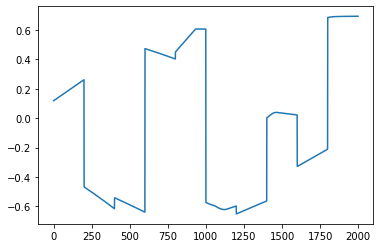

In [11]:
x_axis = range(c.shape[0])
plt.plot(x_axis, c[:,1])
plt.show()

In [8]:
env = gym2.make('Pendulum-v1', dt=0.0001)
x = env.reset()
x = env.state
print(x, 'h(x) =', h(x, alpha))
for i in range(10000):
    u_candidate = input_rule[i]
    u = u_cbf(u_candidate, u_of_x(x, -10., 10., alpha=alpha))
    print(u, u_candidate, u_of_x(x, -10., 10., alpha=alpha))
    x = env.step(np.array([u]))[0]
    x = env.state
    print(x, 'h(x) =',h(x, alpha))
    assert h(x,alpha) >= 0, f'danger state : {x}, h(x) = {h(x, alpha)}'

[-0.20191876  0.20911764] h(x) = 0.8717684380673848
-10.0 -10.0 [-10.0, 10.0]
[-0.20189794  0.20821682] h(x) = 0.8725287361815466
-10.0 -10.0 [-10.0, 10.0]
[-0.20187721  0.20731602] h(x) = 0.873285725747714
-3.8821547861561263 -3.8821547861561263 [-10.0, 10.0]
[-0.20185657  0.20641526] h(x) = 0.874039407218262
2.9485404063659564 2.9485404063659564 [-10.0, 10.0]
[-0.2018359   0.20671453] h(x) = 0.8738004797599429
-10.0 -10.0 [-10.0, 10.0]
[-0.20181532  0.20581382] h(x) = 0.874551918046677
10.0 10.0 [-10.0, 10.0]
[-0.20179471  0.20611315] h(x) = 0.8743136345904676
0.7777354313032592 0.7777354313032592 [-10.0, 10.0]
[-0.2017741   0.20604583] h(x) = 0.8743774440992816
-1.0767807600368124 -1.0767807600368124 [-10.0, 10.0]
[-0.20175356  0.20542218] h(x) = 0.8748989540991124
4.867005839176422 4.867005839176422 [-10.0, 10.0]
[-0.20173299  0.2057216 ] h(x) = 0.8746610465303986
-10.0 -10.0 [-10.0, 10.0]
[-0.2017125   0.20482105] h(x) = 0.8754087393118059
10.0 10.0 [-10.0, 10.0]
[-0.20169199  0.2

[-0.19936678  0.16769793] h(x) = 0.9040076927540751
-6.134385134834385 -6.134385134834385 [-10.0, 10.0]
[-0.1993501   0.16680086] h(x) = 0.9046144830889155
-6.56404657583407 -6.56404657583407 [-10.0, 10.0]
[-0.19933351  0.16590381] h(x) = 0.9052180018699154
-1.3939295851988351 -1.3939295851988351 [-10.0, 10.0]
[-0.19931699  0.16518861] h(x) = 0.9056981837086095
-10.0 -10.0 [-10.0, 10.0]
[-0.19930056  0.16429161] h(x) = 0.9062958200660053
-10.0 -10.0 [-10.0, 10.0]
[-0.19928422  0.16339463] h(x) = 0.9068901859103772
-10.0 -10.0 [-10.0, 10.0]
[-0.19926797  0.16249768] h(x) = 0.9074812815971542
10.0 10.0 [-10.0, 10.0]
[-0.19925169  0.16280076] h(x) = 0.9072905916761973
-8.94729536945373 -8.94729536945373 [-10.0, 10.0]
[-0.1992355   0.16190385] h(x) = 0.9078795009438837
-4.175050702396364 -4.175050702396364 [-10.0, 10.0]
[-0.1992194   0.16100697] h(x) = 0.9084651408750922
4.86030853042673 4.86030853042673 [-10.0, 10.0]
[-0.19920327  0.16131011] h(x) = 0.9082761510777234
-8.814651921996974 -

[-0.19725298  0.11655394] h(x) = 0.9339216170690018
-7.3313921106382605 -7.3313921106382605 [-10.0, 10.0]
[-0.19724142  0.11565998] h(x) = 0.9343413617877823
1.9923720574277972 1.9923720574277972 [-10.0, 10.0]
[-0.19722982  0.11596374] h(x) = 0.9342052182639985
-10.0 -10.0 [-10.0, 10.0]
[-0.19721832  0.11506981] h(x) = 0.934622813014378
8.54404855964446 8.54404855964446 [-10.0, 10.0]
[-0.19720678  0.1153759 ] h(x) = 0.9344862910853736
7.401974947278381 7.401974947278381 [-10.0, 10.0]
[-0.19719521  0.115682  ] h(x) = 0.9343493983538477
-10.0 -10.0 [-10.0, 10.0]
[-0.19718373  0.11478812] h(x) = 0.934765950396613
5.396194831655161 5.396194831655161 [-10.0, 10.0]
[-0.19717222  0.11509426] h(x) = 0.9346297380286996
-1.3124444189385118 -1.3124444189385118 [-10.0, 10.0]
[-0.19716078  0.11440668] h(x) = 0.9349498495236702
-2.907166781881756 -2.907166781881756 [-10.0, 10.0]
[-0.19714943  0.11351285] h(x) = 0.9353617675641358
3.9764643003567124 3.9764643003567124 [-10.0, 10.0]
[-0.19713805  0.11

[-0.19611553  0.08986144] h(x) = 0.9453885404129088
-10.0 -10.0 [-10.0, 10.0]
[-0.19610664  0.08896915] h(x) = 0.9457111679116187
-10.0 -10.0 [-10.0, 10.0]
[-0.19609783  0.08807687] h(x) = 0.9460305709113235
2.717162756925047 2.717162756925047 [-10.0, 10.0]
[-0.19608899  0.08838461] h(x) = 0.9459254305478575
-10.0 -10.0 [-10.0, 10.0]
[-0.19608024  0.08749236] h(x) = 0.9462427149276891
-1.8393818089396985 -1.8393818089396985 [-10.0, 10.0]
[-0.19607158  0.0866483 ] h(x) = 0.9465400810323217
10.0 10.0 [-10.0, 10.0]
[-0.19606288  0.08695608] h(x) = 0.946436629238401
10.0 10.0 [-10.0, 10.0]
[-0.19605415  0.08726386] h(x) = 0.9463328059981438
7.650736395562353 7.650736395562353 [-10.0, 10.0]
[-0.1960454   0.08757166] h(x) = 0.9462286112473198
-10.0 -10.0 [-10.0, 10.0]
[-0.19603673  0.08667947] h(x) = 0.9465429393405023
6.2819713674039015 6.2819713674039015 [-10.0, 10.0]
[-0.19602803  0.0869873 ] h(x) = 0.9464394319513367
-1.5578229632569316 -1.5578229632569316 [-10.0, 10.0]
[-0.19601941  0.0

[-0.19530481  0.05704792] h(x) = 0.9553471032859345
3.553061846483534 3.553061846483534 [-10.0, 10.0]
[-0.19529907  0.05735682] h(x) = 0.9552786640400271
3.896049618754102 3.896049618754102 [-10.0, 10.0]
[-0.1952933   0.05766573] h(x) = 0.9552098531661946
4.266577017670499 4.266577017670499 [-10.0, 10.0]
[-0.19528751  0.05797465] h(x) = 0.9551406706218697
-6.998111257972198 -6.998111257972198 [-10.0, 10.0]
[-0.1952818   0.05708357] h(x) = 0.9553479506477516
-8.322341395302137 -8.322341395302137 [-10.0, 10.0]
[-0.19527618  0.05619251] h(x) = 0.9555520178762302
-0.7470186565668008 -0.7470186565668008 [-10.0, 10.0]
[-0.19527061  0.05567735] h(x) = 0.9556694544906342
-10.0 -10.0 [-10.0, 10.0]
[-0.19526513  0.0547863 ] h(x) = 0.9558684509160409
-5.7333174096605735 -5.7333174096605735 [-10.0, 10.0]
[-0.19525974  0.05389526] h(x) = 0.9560642348803501
0.7284532840219599 0.7284532840219599 [-10.0, 10.0]
[-0.19525436  0.05382276] h(x) = 0.9560819549947261
-8.921208623732205 -8.921208623732205 [-

[-0.19482119  0.03122987] h(x) = 0.9600940961069541
2.3352678070677384 2.3352678070677384 [-10.0, 10.0]
[-0.19481803  0.03153948] h(x) = 0.9600564565555666
0.016357836067471907 0.016357836067471907 [-10.0, 10.0]
[-0.19481491  0.031254  ] h(x) = 0.9600935262127367
-6.949972760483812 -6.949972760483812 [-10.0, 10.0]
[-0.19481187  0.03036363] h(x) = 0.9602044351574618
10.0 10.0 [-10.0, 10.0]
[-0.1948088   0.03067325] h(x) = 0.9601678329119268
-0.6157488183666603 -0.6157488183666603 [-10.0, 10.0]
[-0.19480578  0.03019816] h(x) = 0.9602268486534361
5.3976262362662535 5.3976262362662535 [-10.0, 10.0]
[-0.19480273  0.0305078 ] h(x) = 0.960190443762146
0.1432075701994759 0.1432075701994759 [-10.0, 10.0]
[-0.19479971  0.0302604 ] h(x) = 0.9602216904825044
-0.28558777216865894 -0.28558777216865894 [-10.0, 10.0]
[-0.19479672  0.02988437] h(x) = 0.9602680874079162
7.3439259376378905 7.3439259376378905 [-10.0, 10.0]
[-0.1947937   0.03019402] h(x) = 0.9602320572715959
1.7936349788687815 1.7936349788

[-0.1946015   0.01098376] h(x) = 0.9618889689970714
5.271651573720742 5.271651573720742 [-10.0, 10.0]
[-0.19460037  0.0112937 ] h(x) = 0.9618755993452914
9.347139828427576 9.347139828427576 [-10.0, 10.0]
[-0.19459921  0.01160364] h(x) = 0.9618618574336887
10.0 10.0 [-10.0, 10.0]
[-0.19459802  0.01191358] h(x) = 0.9618477432537587
0.6970715876345658 0.6970715876345658 [-10.0, 10.0]
[-0.19459684  0.01183264] h(x) = 0.9618520476585682
-5.322137567096437 -5.322137567096437 [-10.0, 10.0]
[-0.19459574  0.01094259] h(x) = 0.9618930160142344
-0.652992095683651 -0.652992095683651 [-10.0, 10.0]
[-0.1945947   0.01045663] h(x) = 0.9619142209844737
-10.0 -10.0 [-10.0, 10.0]
[-0.19459374  0.00956658] h(x) = 0.9619502367594833
9.720714148963433 9.720714148963433 [-10.0, 10.0]
[-0.19459275  0.00987653] h(x) = 0.9619385684338569
7.966481855366236 7.966481855366236 [-10.0, 10.0]
[-0.19459174  0.01018648] h(x) = 0.9619265278385799
10.0 10.0 [-10.0, 10.0]
[-0.19459069  0.01049643] h(x) = 0.961914114966199

-10.0 -10.0 [-10.0, 10.0]
[-0.19459989 -0.01262213] h(x) = 0.9618122457962206
-6.539538483726317 -6.539538483726317 [-10.0, 10.0]
[-0.19460124 -0.01351219] h(x) = 0.9617651976217424
-7.582615943495412 -7.582615943495412 [-10.0, 10.0]
[-0.19460268 -0.01440225] h(x) = 0.961714945853059
3.0562005960888197 3.0562005960888197 [-10.0, 10.0]
[-0.19460409 -0.01409232] h(x) = 0.9617320602954977
-10.0 -10.0 [-10.0, 10.0]
[-0.19460559 -0.01498239] h(x) = 0.9616797202857896
2.1216916295484998 2.1216916295484998 [-10.0, 10.0]
[-0.19460706 -0.01467246] h(x) = 0.96169753110213
6.641116955312846 6.641116955312846 [-10.0, 10.0]
[-0.19460849 -0.01436253] h(x) = 0.9617149696250937
10.0 10.0 [-10.0, 10.0]
[-0.1946099 -0.0140526] h(x) = 0.9617320358654602
-6.766762293684456 -6.766762293684456 [-10.0, 10.0]
[-0.19461139 -0.01494268] h(x) = 0.9616798382808137
-4.775164898225286 -4.775164898225286 [-10.0, 10.0]
[-0.19461298 -0.01583275] h(x) = 0.9616244369691506
2.8589286374211147 2.8589286374211147 [-10.0, 1

-4.013595297319988 -4.013595297319988 [-10.0, 10.0]
[-0.19488671 -0.03936932] h(x) = 0.9589192846171365
-8.539702049891844 -8.539702049891844 [-10.0, 10.0]
[-0.19489073 -0.0402598 ] h(x) = 0.9587758986102201
10.0 10.0 [-10.0, 10.0]
[-0.19489473 -0.03995029] h(x) = 0.9588239932171272
-9.794413233419847 -9.794413233419847 [-10.0, 10.0]
[-0.19489881 -0.04084079] h(x) = 0.9586785131874471
10.0 10.0 [-10.0, 10.0]
[-0.19490287 -0.04053129] h(x) = 0.9587273024383202
10.0 10.0 [-10.0, 10.0]
[-0.19490689 -0.04022179] h(x) = 0.9587757196024022
5.0552824038472135 5.0552824038472135 [-10.0, 10.0]
[-0.19491088 -0.03991231] h(x) = 0.9588237647096333
-10.0 -10.0 [-10.0, 10.0]
[-0.19491496 -0.04080283] h(x) = 0.9586784174490568
-6.329863538834593 -6.329863538834593 [-10.0, 10.0]
[-0.19491913 -0.04169335] h(x) = 0.958529862343846
6.740892970359468 6.740892970359468 [-10.0, 10.0]
[-0.19492327 -0.04138388] h(x) = 0.9585796687139061
5.528039722922179 5.528039722922179 [-10.0, 10.0]
[-0.19492737 -0.0410744

10.0 10.0 [-10.0, 10.0]
[-0.19537371 -0.0695621 ] h(x) = 0.9521513400301289
-0.574797644103286 -0.574797644103286 [-10.0, 10.0]
[-0.19538071 -0.07002574] h(x) = 0.9520191669989077
1.0328218621287648 1.0328218621287648 [-10.0, 10.0]
[-0.19538772 -0.07000711] h(x) = 0.9520216507944468
-10.0 -10.0 [-10.0, 10.0]
[-0.19539481 -0.07089833] h(x) = 0.9517677246392403
-3.9985975696854057 -3.9985975696854057 [-10.0, 10.0]
[-0.19540198 -0.07178956] h(x) = 0.951510583463393
2.8712232734451564 2.8712232734451564 [-10.0, 10.0]
[-0.19540913 -0.0714808 ] h(x) = 0.9515962618438965
10.0 10.0 [-10.0, 10.0]
[-0.19541625 -0.07117205] h(x) = 0.9516815678670518
1.4936605431990864 1.4936605431990864 [-10.0, 10.0]
[-0.19542335 -0.07101521] h(x) = 0.951723392430769
10.0 10.0 [-10.0, 10.0]
[-0.19543042 -0.07070649] h(x) = 0.9518081355384417
-2.5283626940285857 -2.5283626940285857 [-10.0, 10.0]
[-0.19543758 -0.07159777] h(x) = 0.9515516702303274
-9.95067717650112 -9.95067717650112 [-10.0, 10.0]
[-0.19544483 -0.07

[-0.19692732 -0.12400049] h(x) = 0.9304673852759293
-3.06962339310898 -3.06962339310898 [-10.0, 10.0]
[-0.19693981 -0.12489398] h(x) = 0.9300176989388357
-10.0 -10.0 [-10.0, 10.0]
[-0.19695239 -0.12578748] h(x) = 0.9295647745853254
-10.0 -10.0 [-10.0, 10.0]
[-0.19696506 -0.126681  ] h(x) = 0.9291086119443627
-10.0 -10.0 [-10.0, 10.0]
[-0.19697782 -0.12757454] h(x) = 0.9286492107429755
0.5479673471964134 0.5479673471964134 [-10.0, 10.0]
[-0.19699059 -0.12770371] h(x) = 0.928578231275737
3.146047056668829 3.146047056668829 [-10.0, 10.0]
[-0.19700333 -0.12739729] h(x) = 0.9287295487555335
-6.581703182856216 -6.581703182856216 [-10.0, 10.0]
[-0.19701616 -0.12829089] h(x) = 0.9282675293305044
-1.4310197197880505 -1.4310197197880505 [-10.0, 10.0]
[-0.19702906 -0.12901381] h(x) = 0.9278904231232317
6.597651126733202 6.597651126733202 [-10.0, 10.0]
[-0.19704193 -0.12870745] h(x) = 0.92804326462651
10.0 10.0 [-10.0, 10.0]
[-0.19705477 -0.1284011 ] h(x) = 0.9281957327102249
-6.915537145236725 -6

10.0 10.0 [-10.0, 10.0]
[-0.19816463 -0.14894569] h(x) = 0.916361139130042
5.211344978066638 5.211344978066638 [-10.0, 10.0]
[-0.1981795 -0.148641 ] h(x) = 0.9165365939929202
-10.0 -10.0 [-10.0, 10.0]
[-0.19819445 -0.14953633] h(x) = 0.915996734235178
10.0 10.0 [-10.0, 10.0]
[-0.19820937 -0.14923167] h(x) = 0.9161728584705191
-10.0 -10.0 [-10.0, 10.0]
[-0.19822439 -0.15012705] h(x) = 0.9156308326207614
3.414559388503409 3.414559388503409 [-10.0, 10.0]
[-0.19823937 -0.14982244] h(x) = 0.9158076260102805
4.98668695205775 4.98668695205775 [-10.0, 10.0]
[-0.19825432 -0.14951785] h(x) = 0.915984046709243
-9.006691508147115 -9.006691508147115 [-10.0, 10.0]
[-0.19826936 -0.15041329] h(x) = 0.9154409434424418
3.557325931817195 3.557325931817195 [-10.0, 10.0]
[-0.19828437 -0.15010875] h(x) = 0.9156180331857952
-1.6641792886525788 -1.6641792886525788 [-10.0, 10.0]
[-0.19829946 -0.15090349] h(x) = 0.9151335985550325
-0.6397774835896703 -0.6397774835896703 [-10.0, 10.0]
[-0.1983146  -0.15139092] h

9.95998034781988 9.95998034781988 [-10.0, 10.0]
[-0.19995441 -0.18004412] h(x) = 0.8951864616075245
5.932742902392425 5.932742902392425 [-10.0, 10.0]
[-0.19997239 -0.17974206] h(x) = 0.8953966294450177
-3.036683751276948 -3.036683751276948 [-10.0, 10.0]
[-0.19999045 -0.18064002] h(x) = 0.8947421846768553
-10.0 -10.0 [-10.0, 10.0]
[-0.2000086  -0.18153801] h(x) = 0.8940844586981889
-4.225747351008081 -4.225747351008081 [-10.0, 10.0]
[-0.20002685 -0.18243603] h(x) = 0.8934234511157405
-3.278962365342411 -3.278962365342411 [-10.0, 10.0]
[-0.20004518 -0.18333407] h(x) = 0.8927591615342725
5.874393260198189 5.874393260198189 [-10.0, 10.0]
[-0.20006348 -0.18303214] h(x) = 0.8929730718584042
-6.901487316056484 -6.901487316056484 [-10.0, 10.0]
[-0.20008188 -0.18393024] h(x) = 0.8923065761072417
5.024855849853717 5.024855849853717 [-10.0, 10.0]
[-0.20010024 -0.18362836] h(x) = 0.8925211416055681
-10.0 -10.0 [-10.0, 10.0]
[-0.20011869 -0.18452652] h(x) = 0.8918524388939953
0.8454461411855352 0.8

[-0.20277087 -0.22303704] h(x) = 0.8593929308534975
5.752145542547931 5.752145542547931 [-10.0, 10.0]
[-0.20279314 -0.22273912] h(x) = 0.8596495119277427
-7.377148830450472 -7.377148830450472 [-10.0, 10.0]
[-0.2028155  -0.22364123] h(x) = 0.8588350733676994
-6.906552002007979 -6.906552002007979 [-10.0, 10.0]
[-0.20283796 -0.22454337] h(x) = 0.8580173124940927
5.268795170803453 5.268795170803453 [-10.0, 10.0]
[-0.20286038 -0.22424555] h(x) = 0.8582755361221129
-10.0 -10.0 [-10.0, 10.0]
[-0.2028829  -0.22514775] h(x) = 0.8574555086080979
10.0 10.0 [-10.0, 10.0]
[-0.20290538 -0.22484999] h(x) = 0.8577143663084361
7.25711550046249 7.25711550046249 [-10.0, 10.0]
[-0.20292784 -0.22455227] h(x) = 0.8579728507661458
4.110870085903925 4.110870085903925 [-10.0, 10.0]
[-0.20295026 -0.22425457] h(x) = 0.858230962141301
7.499703776556743 7.499703776556743 [-10.0, 10.0]
[-0.20297266 -0.22395691] h(x) = 0.8584887005937446
-8.261278412465023 -8.261278412465023 [-10.0, 10.0]
[-0.20299514 -0.22485929] h

[-0.20565464 -0.25476161] h(x) = 0.8278992159857923
-6.2293371396387744 -6.2293371396387744 [-10.0, 10.0]
[-0.2056802  -0.25566792] h(x) = 0.8269634825888756
-10.0 -10.0 [-10.0, 10.0]
[-0.20570586 -0.25657427] h(x) = 0.8260243864609167
-7.271884983489022 -7.271884983489022 [-10.0, 10.0]
[-0.20573161 -0.25748066] h(x) = 0.8250819270412366
10.0 10.0 [-10.0, 10.0]
[-0.20575733 -0.25718708] h(x) = 0.8253735311476973
7.014444661560319 7.014444661560319 [-10.0, 10.0]
[-0.20578302 -0.25689355] h(x) = 0.8256647624615991
10.0 10.0 [-10.0, 10.0]
[-0.20580868 -0.25660005] h(x) = 0.8259556211633847
-1.4494410044618014 -1.4494410044618014 [-10.0, 10.0]
[-0.20583441 -0.25734142] h(x) = 0.8251829857448347
10.0 10.0 [-10.0, 10.0]
[-0.20586011 -0.25704799] h(x) = 0.8254742715741181
6.429744152075532 6.429744152075532 [-10.0, 10.0]
[-0.20588579 -0.25675461] h(x) = 0.8257651850093164
-2.6932608254542516 -2.6932608254542516 [-10.0, 10.0]
[-0.20591156 -0.25766126] h(x) = 0.8248217827717192
10.0 10.0 [-10.0

6.105351453407443 6.105351453407443 [-10.0, 10.0]
[-0.21001091 -0.30138655] h(x) = 0.7742277173431719
8.208690019739226 8.208690019739226 [-10.0, 10.0]
[-0.21004102 -0.30109925] h(x) = 0.7745612508931556
4.925477549719489 4.925477549719489 [-10.0, 10.0]
[-0.2100711 -0.300812 ] h(x) = 0.7748944113964464
-7.100294310686301 -7.100294310686301 [-10.0, 10.0]
[-0.21010127 -0.3017248 ] h(x) = 0.7737817496153754
-0.5354418950131484 -0.5354418950131484 [-10.0, 10.0]
[-0.21013149 -0.30219827] h(x) = 0.7731971701519291
3.4941875940372853 3.4941875940372853 [-10.0, 10.0]
[-0.21016169 -0.30191115] h(x) = 0.7735313814944158
10.0 10.0 [-10.0, 10.0]
[-0.21019185 -0.30162408] h(x) = 0.7738652199005491
0.5357096671627563 0.5357096671627563 [-10.0, 10.0]
[-0.21022203 -0.30177634] h(x) = 0.7736687872500478
-4.065860839509829 -4.065860839509829 [-10.0, 10.0]
[-0.21025229 -0.30268935] h(x) = 0.7725522867827679
-7.474063964766443 -7.474063964766443 [-10.0, 10.0]
[-0.21028265 -0.30360241] h(x) = 0.77143235776

[-0.2133937  -0.34419328] h(x) = 0.7175250974094336
-3.027178014237351 -3.027178014237351 [-10.0, 10.0]
[-0.21342821 -0.34511095] h(x) = 0.7162452641619078
4.134818168417753 4.134818168417753 [-10.0, 10.0]
[-0.2134627  -0.34482867] h(x) = 0.7166200597066552
-10.0 -10.0 [-10.0, 10.0]
[-0.21349727 -0.34574643] h(x) = 0.7153377223996473
0.34845095004228677 0.34845095004228677 [-10.0, 10.0]
[-0.21353187 -0.34595972] h(x) = 0.7150278901715601
-2.5296812460840554 -2.5296812460840554 [-10.0, 10.0]
[-0.21356655 -0.34687759] h(x) = 0.7137412069024038
-10.0 -10.0 [-10.0, 10.0]
[-0.21360133 -0.34779551] h(x) = 0.7124510413355449
0.75531208350819 0.75531208350819 [-10.0, 10.0]
[-0.21363612 -0.34788688] h(x) = 0.7123090388577308
4.309850547216989 4.309850547216989 [-10.0, 10.0]
[-0.21367088 -0.34760491] h(x) = 0.7126864120435811
8.503347088283759 8.503347088283759 [-10.0, 10.0]
[-0.21370561 -0.34732298] h(x) = 0.7130634060250026
-1.7364555633981251 -1.7364555633981251 [-10.0, 10.0]
[-0.21374043 -0.

[-0.21706914 -0.37176112] h(x) = 0.6764683257723106
0.1402141866810913 0.1402141866810913 [-10.0, 10.0]
[-0.21710634 -0.37204211] h(x) = 0.6760341723904668
10.0 10.0 [-10.0, 10.0]
[-0.21714352 -0.37176522] h(x) = 0.6764299382857215
8.896276834623409 8.896276834623409 [-10.0, 10.0]
[-0.21718066 -0.37148838] h(x) = 0.6768253258447814
-5.108091659870128 -5.108091659870128 [-10.0, 10.0]
[-0.21721791 -0.3724116 ] h(x) = 0.6754355875194586
6.453353024255569 6.453353024255569 [-10.0, 10.0]
[-0.21725512 -0.37213487] h(x) = 0.675831495032776
8.256083891456925 8.256083891456925 [-10.0, 10.0]
[-0.21729231 -0.37185819] h(x) = 0.6762270244062717
-10.0 -10.0 [-10.0, 10.0]
[-0.21732958 -0.37278157] h(x) = 0.6748356521834683
-0.12833663164794604 -0.12833663164794604 [-10.0, 10.0]
[-0.2173669  -0.37314351] h(x) = 0.6742794787083433
10.0 10.0 [-10.0, 10.0]
[-0.21740418 -0.372867  ] h(x) = 0.6746758279772
-10.0 -10.0 [-10.0, 10.0]
[-0.21744156 -0.37379054] h(x) = 0.6732804324872158
10.0 10.0 [-10.0, 10.0

10.0 10.0 [-10.0, 10.0]
[-0.22167084 -0.40721521] h(x) = 0.6192135902932181
3.1278473348007925 3.1278473348007925 [-10.0, 10.0]
[-0.22171153 -0.406945  ] h(x) = 0.6196355358049527
-2.012727528481715 -2.012727528481715 [-10.0, 10.0]
[-0.22175232 -0.40787485] h(x) = 0.6181021285860256
-4.302373815934528 -4.302373815934528 [-10.0, 10.0]
[-0.2217932  -0.40880475] h(x) = 0.6165651207155083
10.0 10.0 [-10.0, 10.0]
[-0.22183406 -0.40853472] h(x) = 0.6169884111928253
10.0 10.0 [-10.0, 10.0]
[-0.22187488 -0.40826475] h(x) = 0.6174113210224996
5.528883455685387 5.528883455685387 [-10.0, 10.0]
[-0.22191568 -0.40799484] h(x) = 0.6178338504675233
-4.514926371601287 -4.514926371601287 [-10.0, 10.0]
[-0.22195657 -0.40892499] h(x) = 0.6162959865755591
-10.0 -10.0 [-10.0, 10.0]
[-0.22199756 -0.4098552 ] h(x) = 0.6147545192429297
8.936831310858114 8.936831310858114 [-10.0, 10.0]
[-0.22203852 -0.40958546] h(x) = 0.615178391072228
-0.46470754848557305 -0.46470754848557305 [-10.0, 10.0]
[-0.22207952 -0.410

4.485440943281648 4.485440943281648 [-10.0, 10.0]
[-0.22547132 -0.4312733 ] h(x) = 0.5771693600598716
-10.0 -10.0 [-10.0, 10.0]
[-0.22551454 -0.43220865] h(x) = 0.5755345546753352
8.648137848385435 8.648137848385435 [-10.0, 10.0]
[-0.22555773 -0.43194406] h(x) = 0.5759723600082343
1.9755748900135253 1.9755748900135253 [-10.0, 10.0]
[-0.2256009  -0.43168687] h(x) = 0.5763971314517289
-2.931820382984407 -2.931820382984407 [-10.0, 10.0]
[-0.22564416 -0.4326224 ] h(x) = 0.5747604210441754
10.0 10.0 [-10.0, 10.0]
[-0.2256874  -0.43235801] h(x) = 0.5751983066428386
-3.899594117699046 -3.899594117699046 [-10.0, 10.0]
[-0.22573073 -0.43329367] h(x) = 0.5735588277659895
0.35036367284099523 0.35036367284099523 [-10.0, 10.0]
[-0.22577408 -0.43352429] h(x) = 0.5731394448692527
9.992301925784759 9.992301925784759 [-10.0, 10.0]
[-0.22581741 -0.43326008] h(x) = 0.573577903158992
-6.531335949591267 -6.531335949591267 [-10.0, 10.0]
[-0.22586083 -0.43419594] h(x) = 0.5719346660021867
2.280412288161796 2

-2.041313080410906 -2.041313080410906 [-10.0, 10.0]
[-0.23117047 -0.4769323 ] h(x) = 0.491631372788283
2.881129995070584 2.881129995070584 [-10.0, 10.0]
[-0.23121813 -0.47667598] h(x) = 0.4920981981334618
3.6890328654288815 3.6890328654288815 [-10.0, 10.0]
[-0.23126578 -0.47641972] h(x) = 0.4925646353445605
8.046940591931474 8.046940591931474 [-10.0, 10.0]
[-0.23131339 -0.47616354] h(x) = 0.493030684712457
2.033551448224196 2.033551448224196 [-10.0, 10.0]
[-0.23136098 -0.47590742] h(x) = 0.4934963465277885
10.0 10.0 [-10.0, 10.0]
[-0.23140855 -0.47565138] h(x) = 0.4939616210809514
1.7431264327983644 1.7431264327983644 [-10.0, 10.0]
[-0.2314561  -0.47547246] h(x) = 0.4942799534033443
10.0 10.0 [-10.0, 10.0]
[-0.23150362 -0.47521655] h(x) = 0.49474452959528353
5.1398015796235 5.1398015796235 [-10.0, 10.0]
[-0.23155111 -0.47496072] h(x) = 0.4952087193506016
7.638441505614536 7.638441505614536 [-10.0, 10.0]
[-0.23159858 -0.47470495] h(x) = 0.49567252295878117
-0.4139409829296403 -0.4139409

[-0.24003036 -0.53826355] h(x) = 0.36293013060520696
-10.0 -10.0 [-10.0, 10.0]
[-0.24008428 -0.53922015] h(x) = 0.3608428039815519
6.300658246500738 6.300658246500738 [-10.0, 10.0]
[-0.24013818 -0.53897682] h(x) = 0.3613416219075146
7.960089451717103 7.960089451717103 [-10.0, 10.0]
[-0.24019205 -0.53873358] h(x) = 0.361840039662952
-3.109006875212517 -3.109006875212517 [-10.0, 10.0]
[-0.24024602 -0.53969041] h(x) = 0.35975036592152787
10.0 10.0 [-10.0, 10.0]
[-0.24029997 -0.53944732] h(x) = 0.3602490930305211
-10.0 -10.0 [-10.0, 10.0]
[-0.24035401 -0.54040432] h(x) = 0.35815630172458746
-1.5865946599417067 -1.5865946599417067 [-10.0, 10.0]
[-0.24040813 -0.54123736] h(x) = 0.35632816197147865
-6.4724128280413336 -6.4724128280413336 [-10.0, 10.0]
[-0.24046235 -0.54219451] h(x) = 0.35422807891414
-7.857939707921887 -7.857939707921887 [-10.0, 10.0]
[-0.24051667 -0.54315174] h(x) = 0.35212410778445
-10.0 -10.0 [-10.0, 10.0]
[-0.24057108 -0.54410905] h(x) = 0.3500162473388523
5.4624185933855

KeyboardInterrupt: 